In [15]:
pip install osmnx


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install osmnx geopandas pandas matplotlib openpyxl

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# ADAUGARE ZONE PEnTRU FIECARE LINIE.

Coloane disponibile: Index(['geometry', 'name', 'name:de', 'name:hu', 'place', 'wikidata',
       'old_name', 'addr:city', 'addr:country', 'name:ro', 'name:en',
       'alt_name', 'check_date'],
      dtype='object')

Cartierele mapate cu poligon:
Iris (element_id: N/A)
Bulgaria (element_id: N/A)
Someșeni (element_id: N/A)
Între Lacuri (element_id: N/A)
Mărăști (element_id: N/A)
Sopor (element_id: N/A)
Gheorgheni (element_id: N/A)
Andrei Mureșanu (element_id: N/A)
Centru (element_id: N/A)
Gruia (element_id: N/A)
Grigorescu (element_id: N/A)
Dâmbul Rotund (element_id: N/A)
Plopilor (element_id: N/A)
Mănăștur (element_id: N/A)
Zorilor (element_id: N/A)
Europa (element_id: N/A)
Bună Ziua (element_id: N/A)
Becaș (element_id: N/A)
Borhanci (element_id: N/A)
Făget (element_id: N/A)


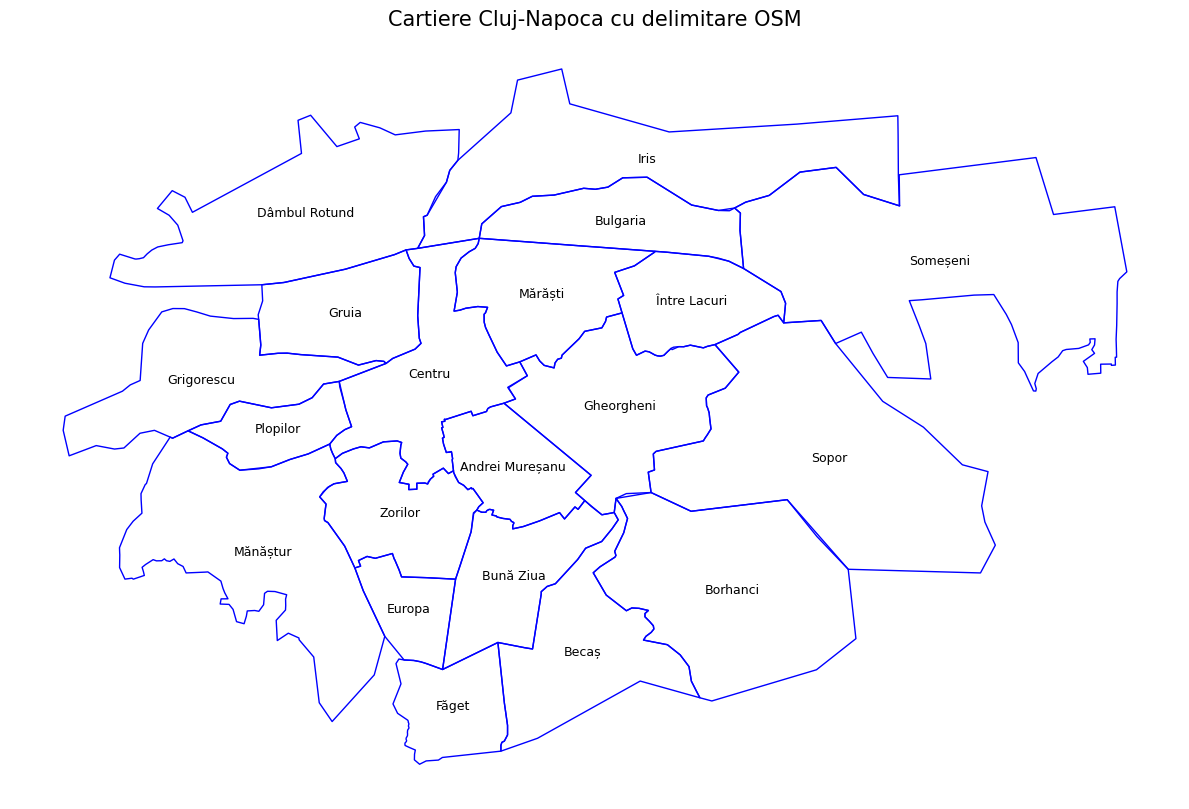

In [19]:
import osmnx as ox
import matplotlib.pyplot as plt

# 1. Obținem poligonul administrativ al Clujului
city = ox.geocode_to_gdf(query="R3277038", by_osmid=True)
polygon = city.iloc[0].geometry

# 2. Extragem cartierele (place=suburb sau neighbourhood)
tags = {"place": ["suburb", "neighbourhood"]}
cartiere = ox.features_from_polygon(polygon, tags=tags)

# 3. Păstrăm doar cele cu geometrie de tip poligon (Polygon/MultiPolygon)
cartiere_poligoane = cartiere[cartiere.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()

# 4. Afișăm numele și identificatorul unic OSM (folosind `element_id`)
print("Coloane disponibile:", cartiere_poligoane.columns)
print("\nCartierele mapate cu poligon:")
for idx, row in cartiere_poligoane.iterrows():
    nume = row['name']
    osm_id = row.get('element_id', 'N/A')  # folosește 'element_id' dacă există
    print(f"{nume} (element_id: {osm_id})")

# 5. Plotăm harta cu denumirile cartierelor în interiorul poligoanelor
fig, ax = plt.subplots(figsize=(12, 12))
cartiere_poligoane.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

for idx, row in cartiere_poligoane.iterrows():
    centroid = row.geometry.centroid
    nume = row['name']
    ax.annotate(nume, (centroid.x, centroid.y), fontsize=9, color='black', ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

ax.set_title("Cartiere Cluj-Napoca cu delimitare OSM", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()


C:\Users\rober\AppData\Local\Temp\ipykernel_31908\4201461715.py:80: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rober\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


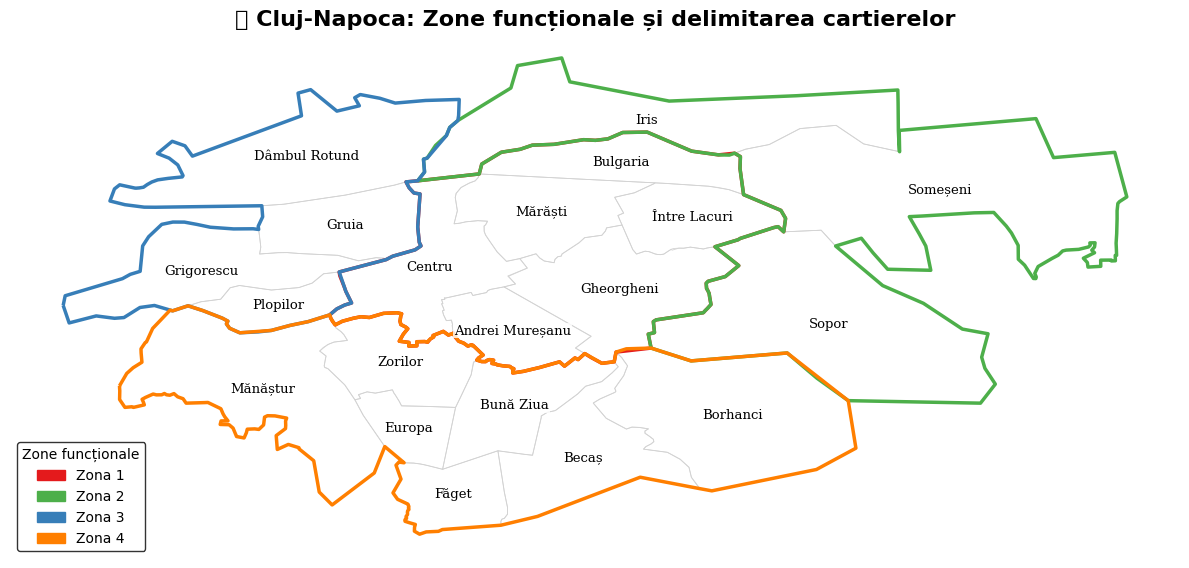

In [55]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

# 1. Poligonul orașului Cluj-Napoca (ID OSM)
city = ox.geocode_to_gdf(query="R3277038", by_osmid=True)
polygon = city.iloc[0].geometry

# 2. Extragem cartierele suburb + neighbourhood
tags = {"place": ["suburb", "neighbourhood"]}
cartiere = ox.features_from_polygon(polygon, tags=tags)
cartiere = cartiere[cartiere.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()

# 3. Repartizare cartiere în zone
zona_dict = {
    "Zona 1": ["Centru", "Andrei Mureșanu", "Gheorgheni", "Între Lacuri", "Mărăști", "Bulgaria"],
    "Zona 2": ["Someșeni", "Iris", "Sopor"],
    "Zona 3": ["Grigorescu", "Gruia", "Dâmbul Rotund", "Plopilor"],
    "Zona 4": ["Mănăștur", "Zorilor", "Europa", "Bună Ziua", "Becaș", "Borhanci", "Făget"]
}
def get_zona(nume):
    for zona, lista in zona_dict.items():
        if nume in lista:
            return zona
    return "Necunoscut"

cartiere["zona"] = cartiere["name"].apply(get_zona)
cartiere = cartiere[cartiere["zona"] != "Necunoscut"].copy()
gdf_zona = cartiere.dissolve(by="zona")

# 4. Culori contururi pentru zone
zona_culori = {
    "Zona 1": "#e41a1c",  # roșu intens
    "Zona 2": "#4daf4a",  # verde
    "Zona 3": "#377eb8",  # albastru
    "Zona 4": "#ff7f00"   # portocaliu
}

# 5. Plotare profesională
fig, ax = plt.subplots(figsize=(12, 12), facecolor="white")
ax.set_aspect('equal')

# Toate cartierele cu contur gri discret
cartiere.boundary.plot(ax=ax, edgecolor="lightgray", linewidth=0.6, zorder=1)

# Contururi groase colorate pentru fiecare zonă
for zona, culoare in zona_culori.items():
    if zona in gdf_zona.index:
        geom = gdf_zona.loc[zona].geometry
        if geom.geom_type == "Polygon":
            geom = MultiPolygon([geom])
        exterior = unary_union([poly.exterior for poly in geom.geoms])
        gpd.GeoSeries([exterior]).plot(ax=ax, edgecolor=culoare, linewidth=2.5, zorder=2)

# Etichete cartiere (font serif + fundal alb ușor transparent)
for idx, row in cartiere.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(
        row['name'],
        (centroid.x, centroid.y),
        fontsize=9.5,
        fontname='DejaVu Serif',
        ha='center',
        va='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.8),
        zorder=3
    )

# Legendă cu margine și fundal alb
patches = [mpatches.Patch(color=color, label=zona) for zona, color in zona_culori.items()]
legend = ax.legend(handles=patches, title="Zone funcționale", loc="lower left", frameon=True, facecolor="white")
legend.get_frame().set_edgecolor("black")

# Titlu final
ax.set_title("📍 Cluj-Napoca: Zone funcționale și delimitarea cartierelor", fontsize=16, fontweight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()


# Calculam Desitatea si Area Km2

In [94]:
import pandas as pd
import numpy as np

# 1. Citește fișierul Excel cu datele inițiale
input_path = r"D:\Disertatie\output_fix.xlsx"   # Ajustează calea dacă este nevoie
df = pd.read_excel(input_path)

# 2. Calculează suprafața zonei ca și cum ar fi un cerc (A = π * r^2), rezultatul în kilometri pătrați (km²)
df["area_km2"] = np.pi * (df["radius"] / 1000) ** 2   # radius în metri, convertit la km

# 3. Calculează densitatea populației (persoane/km²)
df["density"] = df["population"] / df["area_km2"]

# 4. Salvează datele cu noile coloane, suprascriind fișierul original
df.to_excel(input_path, index=False)

print("✅ Fișierul a fost actualizat cu coloanele 'area_km2' și 'density'.")


✅ Fișierul a fost actualizat cu coloanele 'area_km2' și 'density'.


# Calculam Indicii I1-I5 conform coordonatelor.

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Încarcă fișierul local
file_path = "D:/Disertatie/output.xlsx"  # Asigură-te că fișierul există aici
df = pd.read_excel(file_path)

# 2. Calculează aria în km² și densitatea
df["area_km2"] = np.pi * (df["radius"] / 1000) ** 2
df["density"] = df["population"] / df["area_km2"]

# 3. Normalizează scorurile
scaler = MinMaxScaler()

I1_cols = ["a_f", "b_f", "c_f", "d_f"]
I2_cols = ["e_f", "f_f", "density"]
I3_cols = ["g_f", "h_f"]
I4_cols = ["i_f", "l_f"]

for cols in [I1_cols, I2_cols, I3_cols, I4_cols]:
    df[cols] = scaler.fit_transform(df[cols])

# 4. Calculează indici compoziți
df["I1"] = df[I1_cols].mean(axis=1)
df["I2"] = df[I2_cols].mean(axis=1)
df["I3"] = df[I3_cols].mean(axis=1)
df["I4"] = df[I4_cols].mean(axis=1)
df["score_final"] = df[["I1", "I2", "I3", "I4"]].mean(axis=1)

# 5. Salvează fișierul nou
output_path = "D:/Disertatie/output_with_indices.xlsx"
df.to_excel(output_path, index=False)

print("✅ Fișierul a fost salvat cu indici compoziți în:", output_path)


✅ Fișierul a fost salvat cu indici compoziți în: D:/Disertatie/output_with_indices.xlsx


# Adaugarea zonelor pentru fiecare din coordoante

In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Încarcă fișierul local
file_path = "D:/Disertatie/output.xlsx"
df = pd.read_excel(file_path)

# 2. Calculează aria în km² și densitatea
df["area_km2"] = np.pi * (df["radius"] / 1000) ** 2
df["density"] = df["population"] / df["area_km2"]

# 3. Normalizează scorurile (inclusiv noile grupe)
scaler = MinMaxScaler()

# Grupe noi, pe logica ta:
I1_cols = ["a_f", "b_f"]               # Educație
I2_cols = ["e_f", "f_f", "density"]    # Calitatea vieții (fost I2)
I3_cols = ["g_f", "h_f"]               # Servicii esențiale (fost I3)
I4_cols = ["i_f", "l_f"]               # Aprovizionare (fost I4)
I5_cols = ["c_f", "d_f"]               # Medical

for cols in [I1_cols, I2_cols, I3_cols, I4_cols, I5_cols]:
    df[cols] = scaler.fit_transform(df[cols])

# 4. Calculează noii indici compoziți
df["I1"] = df[I1_cols].mean(axis=1)  # Educație
df["I2"] = df[I5_cols].mean(axis=1)  # Medical
df["I3"] = df[I2_cols].mean(axis=1)  # Calitate viață/bunăstare
df["I4"] = df[I3_cols].mean(axis=1)  # Servicii esențiale/mobilitate
df["I5"] = df[I4_cols].mean(axis=1)  # Acces la alimente

# 5. Score final ca media celor 5 indici
df["score_final"] = df[["I1", "I2", "I3", "I4", "I5"]].mean(axis=1)

# 6. Salvează fișierul nou
output_path = "D:/Disertatie/output_with_5indices.xlsx"
df.to_excel(output_path, index=False)

print("✅ Fișierul a fost salvat cu 5 indici compoziți în:", output_path)


✅ Fișierul a fost salvat cu 5 indici compoziți în: D:/Disertatie/output_with_5indices.xlsx


# **Incepem sa facem hărți choropleth pentru fiecare indice**


count    512.000000
mean      21.354834
std       14.481269
min        2.100000
25%       11.203750
50%       17.612500
75%       26.693750
max       80.235000
Name: I1, dtype: float64


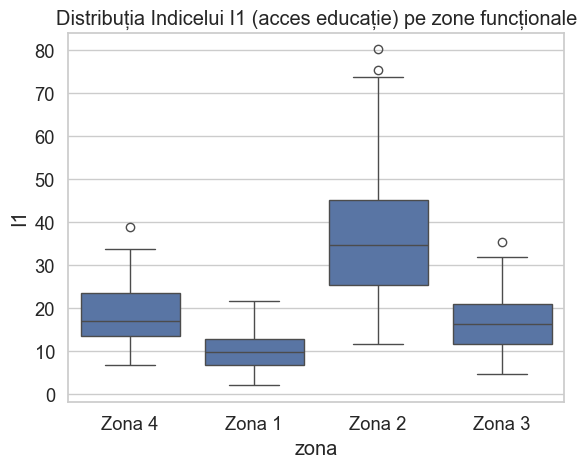

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('output_fix_with_zones.xlsx')

# Calculul indicelui I1 (media acces educație - pe jos)
df['I1'] = df[['a_f', 'b_f']].mean(axis=1)

print(df['I1'].describe())
sns.boxplot(x='zona', y='I1', data=df)
plt.title("Distribuția Indicelui I1 (acces educație) pe zone funcționale")
plt.show()




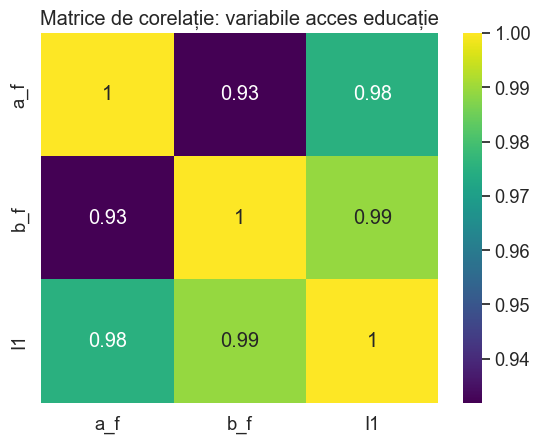

In [101]:
corr_edu = df[['a_f', 'b_f', 'I1']].corr()
sns.heatmap(corr_edu, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile acces educație")
plt.show()



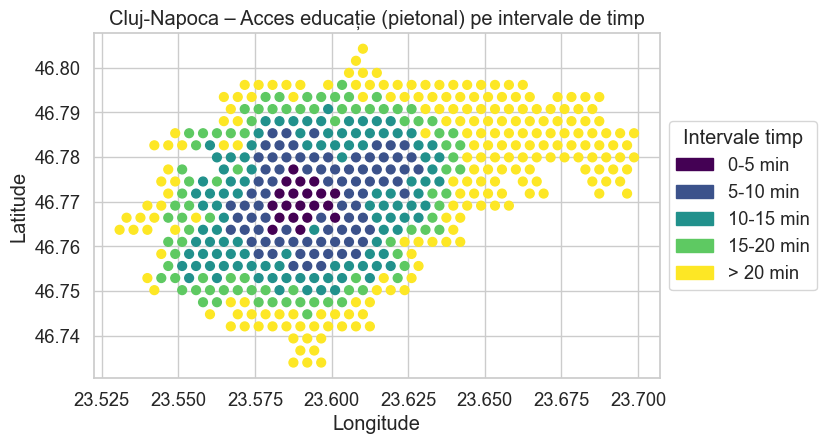


--- Interpretare automată pentru disertație ---
Figura X ilustrează accesibilitatea pietonală la facilități educaționale în Cluj-Napoca, clasificată pe intervale de timp.
Un total de 209 puncte, reprezentând 40.82% din suprafața analizată, se încadrează în intervalul de acces optim (0–15 minute).
• 20 puncte (3.91%) sunt situate la mai puțin de 5 minute de mers – acces foarte bun.
• 82 puncte (16.02%) au un acces bun, între 5–10 minute.
• 107 puncte (20.90%) beneficiază de un acces moderat, între 10–15 minute.
Restul de 303 puncte (59.18%) se află în afara intervalului optim, indicând zone cu accesibilitate slabă.
• 90 puncte (17.58%) necesită 15–20 minute de mers.
• 213 puncte (41.60%) necesită peste 20 de minute – reflectând un deficit major de infrastructură educațională.


In [113]:
import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Funcție de clasificare a accesului
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

# Clase de timp ordonate
time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# Calcule: medie și clasă
df['edu_mean'] = df[['a_f', 'b_f']].mean(axis=1)
df['edu_class'] = df['edu_mean'].apply(classify_accessibility).astype(time_class_type)

# Convertire la GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# HARTĂ
cmap = plt.get_cmap('viridis', 5)
custom_colors = [cmap(i / 4) for i in range(5)]

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='edu_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces educație (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# INTERPRETARE REDACTABILĂ
print("\n--- Interpretare automată pentru disertație ---")

total_points = len(gdf)
counts = gdf['edu_class'].value_counts().sort_index()
percentages = counts / total_points * 100

# Puncte cu acces < 15 min
within_15 = counts.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct = within_15 / total_points * 100

outside_15 = total_points - within_15
outside_15_pct = 100 - within_15_pct

print(f"Figura X ilustrează accesibilitatea pietonală la facilități educaționale în Cluj-Napoca, clasificată pe intervale de timp.")
print(f"Un total de {within_15} puncte, reprezentând {within_15_pct:.2f}% din suprafața analizată, se încadrează în intervalul de acces optim (0–15 minute).")

if '0-5 min' in counts:
    print(f"• {counts['0-5 min']} puncte ({percentages['0-5 min']:.2f}%) sunt situate la mai puțin de 5 minute de mers – acces foarte bun.")
if '5-10 min' in counts:
    print(f"• {counts['5-10 min']} puncte ({percentages['5-10 min']:.2f}%) au un acces bun, între 5–10 minute.")
if '10-15 min' in counts:
    print(f"• {counts['10-15 min']} puncte ({percentages['10-15 min']:.2f}%) beneficiază de un acces moderat, între 10–15 minute.")

if '15-20 min' in counts or '> 20 min' in counts:
    print(f"Restul de {outside_15} puncte ({outside_15_pct:.2f}%) se află în afara intervalului optim, indicând zone cu accesibilitate slabă.")

if '15-20 min' in counts:
    print(f"• {counts['15-20 min']} puncte ({percentages['15-20 min']:.2f}%) necesită 15–20 minute de mers.")
if '> 20 min' in counts:
    print(f"• {counts['> 20 min']} puncte ({percentages['> 20 min']:.2f}%) necesită peste 20 de minute – reflectând un deficit major de infrastructură educațională.")


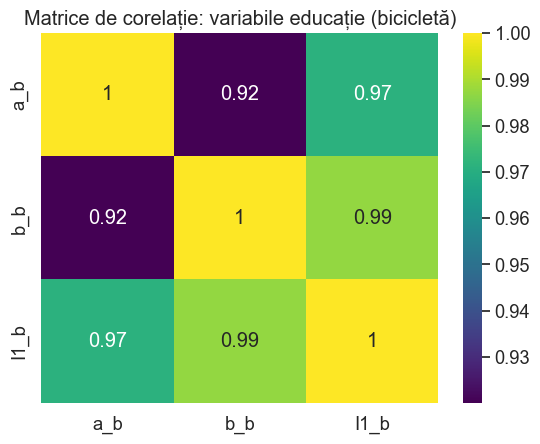

In [105]:
corr_edu_bike = df[['a_b', 'b_b', 'I1_b']].corr()
sns.heatmap(corr_edu_bike, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile educație (bicicletă)")
plt.show()


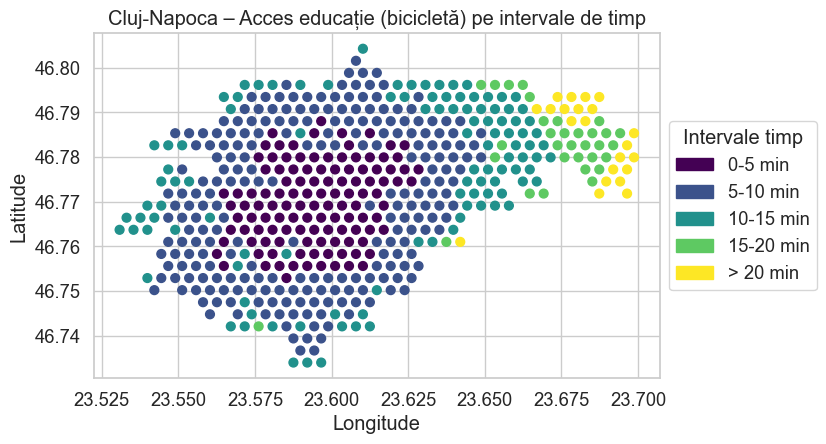


--- Interpretare automată pentru disertație (bicicletă) ---
Figura Y ilustrează accesibilitatea cu bicicleta la facilități educaționale în Cluj-Napoca, clasificate pe intervale temporale.
În total, 458 puncte (reprezentând 89.45% din suprafața analizată) se află în zona optimă de acces cu bicicleta (0–15 minute).
• 118 puncte (23.05%) se află la cel mult 5 minute distanță – acces excelent.
• 231 puncte (45.12%) beneficiază de acces bun (5–10 minute).
• 109 puncte (21.29%) se află la distanțe moderate (10–15 minute).
Restul de 54 puncte (10.55%) depășesc intervalul de 15 minute și sugerează o accesibilitate redusă.
• 32 puncte (6.25%) necesită între 15 și 20 minute de mers cu bicicleta.
• 22 puncte (4.30%) depășesc 20 de minute – indicând deficiențe de infrastructură educațională în zonele periferice.


In [116]:
# Calcule: medie și clasificare pe bicicletă
df['edu_bike_mean'] = df[['a_b', 'b_b']].mean(axis=1)
df['edu_bike_class'] = df['edu_bike_mean'].apply(classify_accessibility).astype(time_class_type)

# Convertire la GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# HARTĂ
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='edu_bike_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces educație (bicicletă) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# INTERPRETARE REDACTABILĂ – EDUCAȚIE PE BICICLETĂ
print("\n--- Interpretare automată pentru disertație (bicicletă) ---")

total_points_bike = len(gdf)
counts_bike = gdf['edu_bike_class'].value_counts().sort_index()
percentages_bike = counts_bike / total_points_bike * 100

within_15_bike = counts_bike.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_bike = within_15_bike / total_points_bike * 100

outside_15_bike = total_points_bike - within_15_bike
outside_15_pct_bike = 100 - within_15_pct_bike

print(f"Figura Y ilustrează accesibilitatea cu bicicleta la facilități educaționale în Cluj-Napoca, clasificate pe intervale temporale.")
print(f"În total, {within_15_bike} puncte (reprezentând {within_15_pct_bike:.2f}% din suprafața analizată) se află în zona optimă de acces cu bicicleta (0–15 minute).")

if '0-5 min' in counts_bike:
    print(f"• {counts_bike['0-5 min']} puncte ({percentages_bike['0-5 min']:.2f}%) se află la cel mult 5 minute distanță – acces excelent.")
if '5-10 min' in counts_bike:
    print(f"• {counts_bike['5-10 min']} puncte ({percentages_bike['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_bike:
    print(f"• {counts_bike['10-15 min']} puncte ({percentages_bike['10-15 min']:.2f}%) se află la distanțe moderate (10–15 minute).")

if '15-20 min' in counts_bike or '> 20 min' in counts_bike:
    print(f"Restul de {outside_15_bike} puncte ({outside_15_pct_bike:.2f}%) depășesc intervalul de 15 minute și sugerează o accesibilitate redusă.")

if '15-20 min' in counts_bike:
    print(f"• {counts_bike['15-20 min']} puncte ({percentages_bike['15-20 min']:.2f}%) necesită între 15 și 20 minute de mers cu bicicleta.")
if '> 20 min' in counts_bike:
    print(f"• {counts_bike['> 20 min']} puncte ({percentages_bike['> 20 min']:.2f}%) depășesc 20 de minute – indicând deficiențe de infrastructură educațională în zonele periferice.")


In [107]:
stat_zone = df.groupby('zona')['I1_b'].agg(['mean', 'std', 'min', 'max', 'count'])
print(stat_zone)


             mean       std    min     max  count
zona                                             
Zona 1   4.770903  1.749063  1.455   8.675    144
Zona 2  14.061208  5.330932  4.895  29.420    149
Zona 3   7.605545  2.819412  3.030  14.970    101
Zona 4   7.725593  2.467562  2.935  15.195    118


In [111]:
import pandas as pd
import numpy as np

# 1. Media celor două variabile pentru educație, pe foot și bike
df['I1'] = df[['a_f', 'b_f']].mean(axis=1)
df['I1_b'] = df[['a_b', 'b_b']].mean(axis=1)

# 2. Conversie densitate la persoane/ha
df['density_ha'] = df['density'] / 100  # Persoane pe hectar

# 3. Clasificare accesibilitate pe intervale de timp (ca mai sus)
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return 'Grey area'

df['I1_class'] = df['I1'].apply(classify_accessibility)
df['I1_b_class'] = df['I1_b'].apply(classify_accessibility)

# 4. Agregare statistici pentru densitate populație pe fiecare clasă de acces (pietonal)
pop_density_stats_foot = df.groupby('I1_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# 5. Agregare statistici pentru densitate populație pe fiecare clasă de acces (bicicletă)
pop_density_stats_bike = df.groupby('I1_b_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# 6. Îmbinare într-un singur tabel pentru comparație ușoară
table = pd.DataFrame({
    'Time class': pop_density_stats_foot['I1_class'],
    'Mean density (Foot)': np.round(pop_density_stats_foot['Mean_density'], 2),
    'Std dev (Foot)': np.round(pop_density_stats_foot['Std_density'], 2),
    'Min (Foot)': np.round(pop_density_stats_foot['Min_density'], 2),
    'Max (Foot)': np.round(pop_density_stats_foot['Max_density'], 2),
    'Mean density (Bike)': np.round(pop_density_stats_bike['Mean_density'], 2),
    'Std dev (Bike)': np.round(pop_density_stats_bike['Std_density'], 2),
    'Min (Bike)': np.round(pop_density_stats_bike['Min_density'], 2),
    'Max (Bike)': np.round(pop_density_stats_bike['Max_density'], 2),
})

print(table)


  Time class  Mean density (Foot)  Std dev (Foot)  Min (Foot)  Max (Foot)  \
0    0-5 min                50.47            1.85       45.46       52.64   
1  10-15 min                36.17           11.08        8.35       50.73   
2  15-20 min                24.35           12.92        0.00       50.25   
3   5-10 min                43.45            8.49       18.12       51.88   
4  Grey area                12.65           11.79        0.00       47.39   

   Mean density (Bike)  Std dev (Bike)  Min (Bike)  Max (Bike)  
0                43.91            8.75       15.66       52.64  
1                12.95           12.21        0.00       48.68  
2                 9.22            8.03        0.00       29.91  
3                27.04           14.58        0.00       51.00  
4                 8.91            8.01        0.00       28.80  


# **Al doilea Indice calculat**


count    512.000000
mean      19.269277
std       14.978552
min        1.500000
25%        8.088750
50%       15.045000
75%       24.656250
max       77.395000
Name: I2, dtype: float64


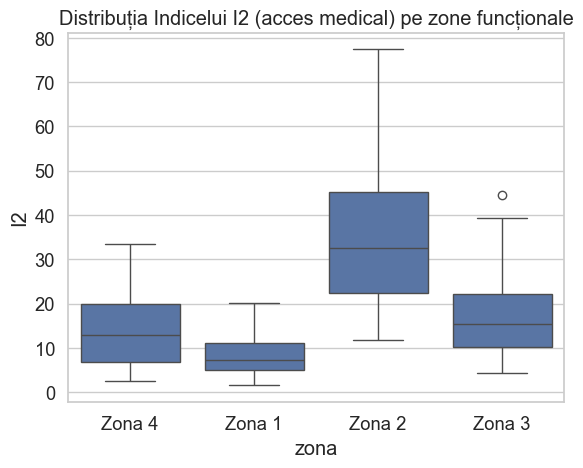

In [195]:
df['I2'] = df[['c_f', 'd_f']].mean(axis=1)
print(df['I2'].describe())
sns.boxplot(x='zona', y='I2', data=df)
plt.title("Distribuția Indicelui I2 (acces medical) pe zone funcționale")
plt.show()


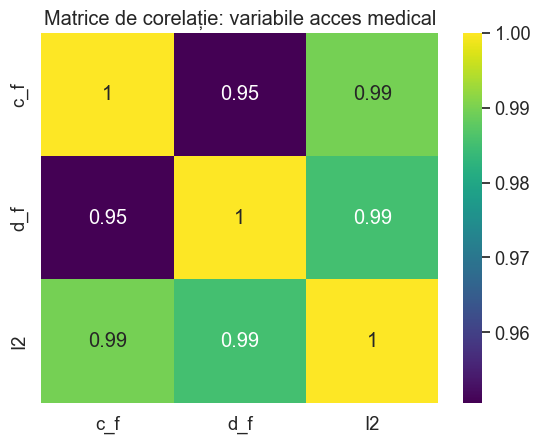

In [141]:
corr_med = df[['c_f', 'd_f', 'I2']].corr()
sns.heatmap(corr_med, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile acces medical")
plt.show()


In [203]:
import pandas as pd
import geopandas as gpd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Încarcă datele
df = pd.read_excel('output_fix_with_zones.xlsx')

# Media acces medical: walk și bike
df['medical_mean_foot'] = df[['c_f', 'd_f']].mean(axis=1)
df['medical_mean_bike'] = df[['c_b', 'd_b']].mean(axis=1)

# Clasificare intervale
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# Clasificare pentru walk și bike
df['medical_class_foot'] = df['medical_mean_foot'].apply(classify_accessibility).astype(time_class_type)
df['medical_class_bike'] = df['medical_mean_bike'].apply(classify_accessibility).astype(time_class_type)




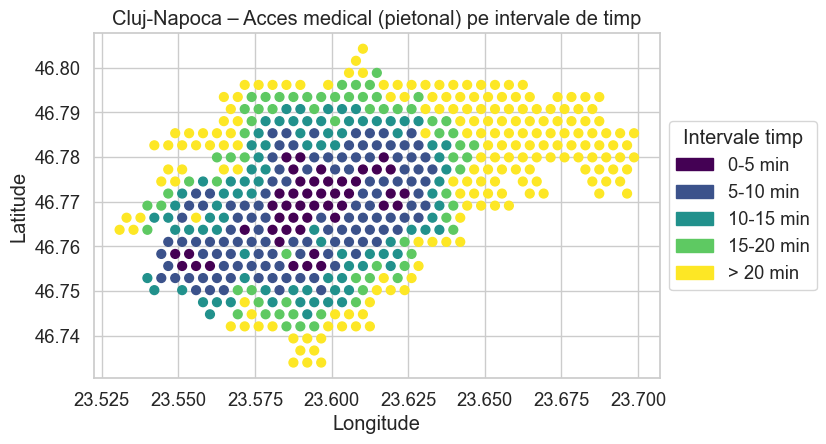


--- Interpretare automată pentru disertație (acces medical pietonal) ---
Figura X ilustrează accesibilitatea pietonală la facilități medicale în Cluj-Napoca, clasificată pe intervale temporale.
În total, 255 puncte (reprezentând 49.80% din suprafața analizată) se află în zona optimă de acces pietonal (0–15 minute).
• 47 puncte (9.18%) se află la cel mult 5 minute distanță – acces excelent.
• 118 puncte (23.05%) beneficiază de acces bun (5–10 minute).
• 90 puncte (17.58%) se află la distanțe moderate (10–15 minute).
Restul de 257 puncte (50.20%) depășesc intervalul de 15 minute și sugerează o accesibilitate redusă.
• 70 puncte (13.67%) necesită între 15 și 20 minute de mers pe jos.
• 187 puncte (36.52%) depășesc 20 de minute – indicând deficiențe de infrastructură medicală în zonele periferice.


In [194]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from pandas.api.types import CategoricalDtype

# 1. Clasificare timp
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# 2. Calcule pentru medical_class_foot
df['medical_mean_foot'] = df[['c_f', 'd_f']].mean(axis=1)
df['medical_class_foot'] = df['medical_mean_foot'].apply(classify_accessibility).astype(time_class_type)

# 3. Creare GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 4. Hartă – Acces medical pietonal
cmap = plt.get_cmap('viridis', 5)
custom_colors = [cmap(i / 4) for i in range(5)]

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='medical_class_foot', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)

handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces medical (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 5. INTERPRETARE – redactabilă pentru disertație
print("\n--- Interpretare automată pentru disertație (acces medical pietonal) ---")

total_points_foot = len(gdf)
counts_foot = gdf['medical_class_foot'].value_counts().sort_index()
percentages_foot = counts_foot / total_points_foot * 100

within_15_foot = counts_foot.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_foot = within_15_foot / total_points_foot * 100

outside_15_foot = total_points_foot - within_15_foot
outside_15_pct_foot = 100 - within_15_pct_foot

print(f"Figura X ilustrează accesibilitatea pietonală la facilități medicale în Cluj-Napoca, clasificată pe intervale temporale.")
print(f"În total, {within_15_foot} puncte (reprezentând {within_15_pct_foot:.2f}% din suprafața analizată) se află în zona optimă de acces pietonal (0–15 minute).")

if '0-5 min' in counts_foot:
    print(f"• {counts_foot['0-5 min']} puncte ({percentages_foot['0-5 min']:.2f}%) se află la cel mult 5 minute distanță – acces excelent.")
if '5-10 min' in counts_foot:
    print(f"• {counts_foot['5-10 min']} puncte ({percentages_foot['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_foot:
    print(f"• {counts_foot['10-15 min']} puncte ({percentages_foot['10-15 min']:.2f}%) se află la distanțe moderate (10–15 minute).")

if '15-20 min' in counts_foot or '> 20 min' in counts_foot:
    print(f"Restul de {outside_15_foot} puncte ({outside_15_pct_foot:.2f}%) depășesc intervalul de 15 minute și sugerează o accesibilitate redusă.")

if '15-20 min' in counts_foot:
    print(f"• {counts_foot['15-20 min']} puncte ({percentages_foot['15-20 min']:.2f}%) necesită între 15 și 20 minute de mers pe jos.")
if '> 20 min' in counts_foot:
    print(f"• {counts_foot['> 20 min']} puncte ({percentages_foot['> 20 min']:.2f}%) depășesc 20 de minute – indicând deficiențe de infrastructură medicală în zonele periferice.")


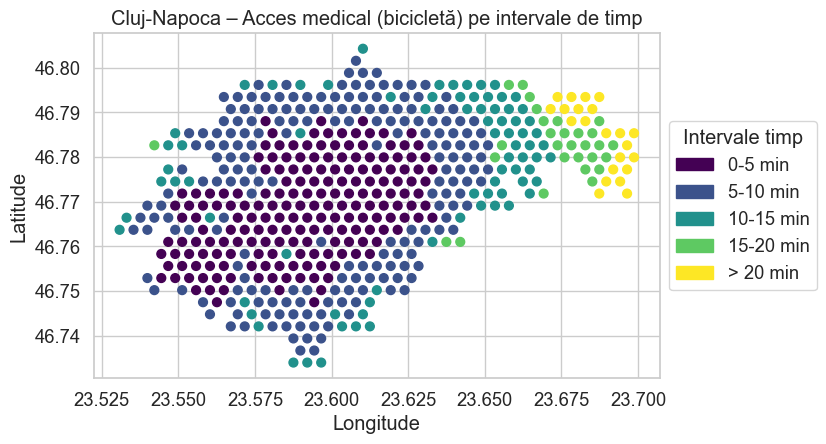


--- Interpretare automată pentru disertație (acces medical cu bicicleta) ---
Figura Y ilustrează accesibilitatea cu bicicleta la facilități medicale în Cluj-Napoca, clasificată pe intervale temporale.
În total, 461 puncte (reprezentând 90.04% din suprafața analizată) se află în zona optimă de acces cu bicicleta (0–15 minute).
• 186 puncte (36.33%) se află la cel mult 5 minute distanță – acces excelent.
• 197 puncte (38.48%) beneficiază de acces bun (5–10 minute).
• 78 puncte (15.23%) se află la distanțe moderate (10–15 minute).
Restul de 51 puncte (9.96%) depășesc intervalul de 15 minute și sugerează o accesibilitate redusă.
• 29 puncte (5.66%) necesită între 15 și 20 minute de mers cu bicicleta.
• 22 puncte (4.30%) depășesc 20 de minute – indicând deficiențe de infrastructură medicală în zonele periferice.


In [178]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from pandas.api.types import CategoricalDtype

# 1. Definire funcție de clasificare
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

# 2. Definire categorii ordonate
time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# 3. Calculare medie și clasificare pentru bicicletă (I2_b)
df['medical_mean_bike'] = df[['c_b', 'd_b']].mean(axis=1)
df['medical_class_bike'] = df['medical_mean_bike'].apply(classify_accessibility).astype(time_class_type)

# 4. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 5. HARTĂ – Acces medical cu bicicleta
cmap = plt.get_cmap('viridis', 5)
custom_colors = [cmap(i / 4) for i in range(5)]

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='medical_class_bike', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)

handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces medical (bicicletă) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 6. INTERPRETARE AUTOMATĂ – disertație
print("\n--- Interpretare automată pentru disertație (acces medical cu bicicleta) ---")

total_points_bike = len(gdf)
counts_bike = gdf['medical_class_bike'].value_counts().sort_index()
percentages_bike = counts_bike / total_points_bike * 100

within_15_bike = counts_bike.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_bike = within_15_bike / total_points_bike * 100

outside_15_bike = total_points_bike - within_15_bike
outside_15_pct_bike = 100 - within_15_pct_bike

print(f"Figura Y ilustrează accesibilitatea cu bicicleta la facilități medicale în Cluj-Napoca, clasificată pe intervale temporale.")
print(f"În total, {within_15_bike} puncte (reprezentând {within_15_pct_bike:.2f}% din suprafața analizată) se află în zona optimă de acces cu bicicleta (0–15 minute).")

if '0-5 min' in counts_bike:
    print(f"• {counts_bike['0-5 min']} puncte ({percentages_bike['0-5 min']:.2f}%) se află la cel mult 5 minute distanță – acces excelent.")
if '5-10 min' in counts_bike:
    print(f"• {counts_bike['5-10 min']} puncte ({percentages_bike['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_bike:
    print(f"• {counts_bike['10-15 min']} puncte ({percentages_bike['10-15 min']:.2f}%) se află la distanțe moderate (10–15 minute).")

if '15-20 min' in counts_bike or '> 20 min' in counts_bike:
    print(f"Restul de {outside_15_bike} puncte ({outside_15_pct_bike:.2f}%) depășesc intervalul de 15 minute și sugerează o accesibilitate redusă.")

if '15-20 min' in counts_bike:
    print(f"• {counts_bike['15-20 min']} puncte ({percentages_bike['15-20 min']:.2f}%) necesită între 15 și 20 minute de mers cu bicicleta.")
if '> 20 min' in counts_bike:
    print(f"• {counts_bike['> 20 min']} puncte ({percentages_bike['> 20 min']:.2f}%) depășesc 20 de minute – indicând deficiențe de infrastructură medicală în zonele periferice.")



In [149]:
import pandas as pd
import numpy as np

# Încarcă datele
df = pd.read_excel('output_fix_with_zones.xlsx')

# Transformă densitatea în persoane/ha (dacă density e pe km²)
df['density_ha'] = df['density'] / 100

# Media pentru medical - walk (I2) și bike (I2_b)
df['I2'] = df[['c_f', 'd_f']].mean(axis=1)
df['I2_b'] = df[['c_b', 'd_b']].mean(axis=1)

# Clasificare pe intervale de timp
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return 'Grey area'

df['I2_class'] = df['I2'].apply(classify_accessibility)
df['I2_b_class'] = df['I2_b'].apply(classify_accessibility)

# Statistici densitate pe clase (walk)
pop_density_stats_foot = df.groupby('I2_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# Statistici densitate pe clase (bike)
pop_density_stats_bike = df.groupby('I2_b_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# Îmbinare în tabel comun, ordonat pe intervale
all_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', 'Grey area']
table = pd.DataFrame({'Time class': all_classes})

table = table.merge(pop_density_stats_foot, left_on='Time class', right_on='I2_class', how='left')
table = table.merge(pop_density_stats_bike, left_on='Time class', right_on='I2_b_class', how='left', suffixes=(' (Foot)', ' (Bike)'))

table = table[['Time class',
               'Mean_density (Foot)', 'Std_density (Foot)', 'Min_density (Foot)', 'Max_density (Foot)',
               'Mean_density (Bike)', 'Std_density (Bike)', 'Min_density (Bike)', 'Max_density (Bike)']]

# Rotunjire la 2 zecimale
table = table.round(2)

print("\nTabel statistici pentru I2 (acces medical), walk vs bike:\n")
print(table)




Tabel statistici pentru I2 (acces medical), walk vs bike:

  Time class  Mean_density (Foot)  Std_density (Foot)  Min_density (Foot)  \
0    0-5 min                47.32                6.56               18.12   
1   5-10 min                39.73                9.86               15.66   
2  10-15 min                28.85               13.99                0.00   
3  15-20 min                20.81               13.58                0.00   
4  Grey area                12.64               11.90                0.00   

   Max_density (Foot)  Mean_density (Bike)  Std_density (Bike)  \
0               52.64                41.08               10.16   
1               51.88                21.48               14.58   
2               50.25                12.50               11.83   
3               47.97                 9.43                8.64   
4               47.39                 9.44                7.62   

   Min_density (Bike)  Max_density (Bike)  
0                5.64               

# **Al treilea Indice calculat**

Statistici descriptive I3 (walk):
 count    512.000000
mean      15.289385
std       11.528375
min        1.525000
25%        6.666250
50%       12.070000
75%       20.127500
max       65.885000
Name: I3, dtype: float64
Statistici descriptive I3 (bike):
 count    512.00000
mean       6.37957
std        4.09824
min        0.71000
25%        3.46250
50%        5.27750
75%        8.10250
max       24.36500
Name: I3_b, dtype: float64


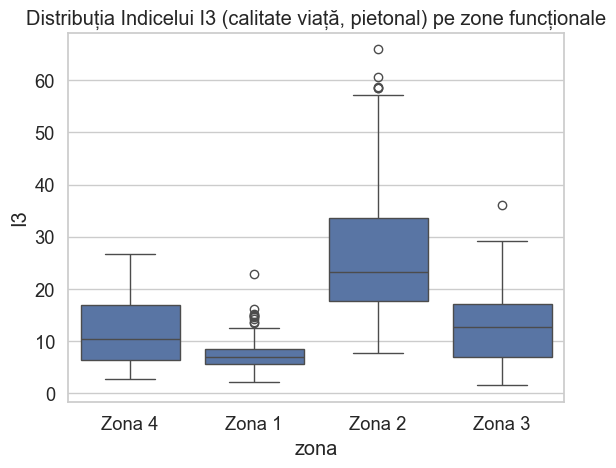

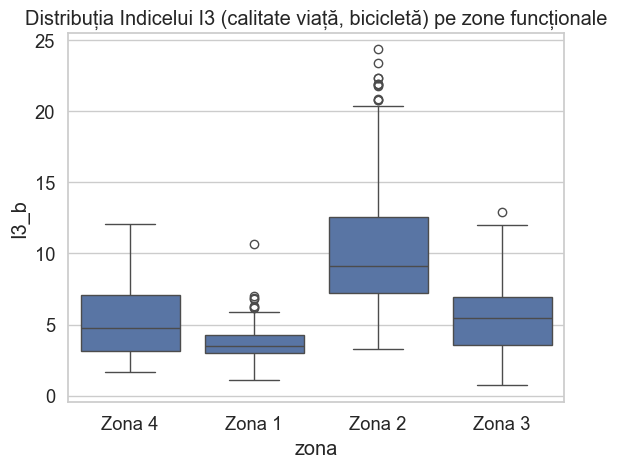

In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('output_fix_with_zones.xlsx')

# Calculează indicii I3 pentru walk și bike
df['I3'] = df[['e_f', 'f_f']].mean(axis=1)
df['I3_b'] = df[['e_b', 'f_b']].mean(axis=1)

# Statistici descriptive
print("Statistici descriptive I3 (walk):\n", df['I3'].describe())
print("Statistici descriptive I3 (bike):\n", df['I3_b'].describe())

# Boxplot distribuție pe zone funcționale (walk)
sns.boxplot(x='zona', y='I3', data=df)
plt.title("Distribuția Indicelui I3 (calitate viață, pietonal) pe zone funcționale")
plt.show()

# Boxplot distribuție pe zone funcționale (bike)
sns.boxplot(x='zona', y='I3_b', data=df)
plt.title("Distribuția Indicelui I3 (calitate viață, bicicletă) pe zone funcționale")
plt.show()



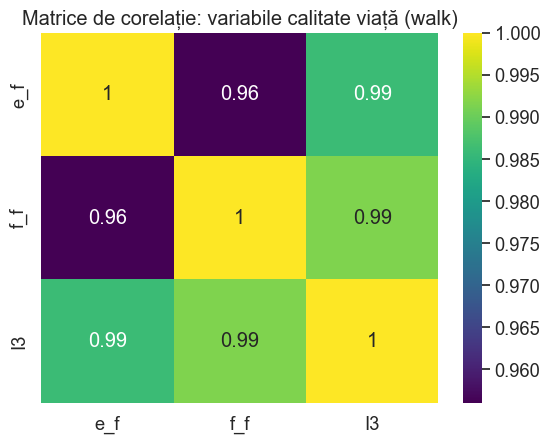

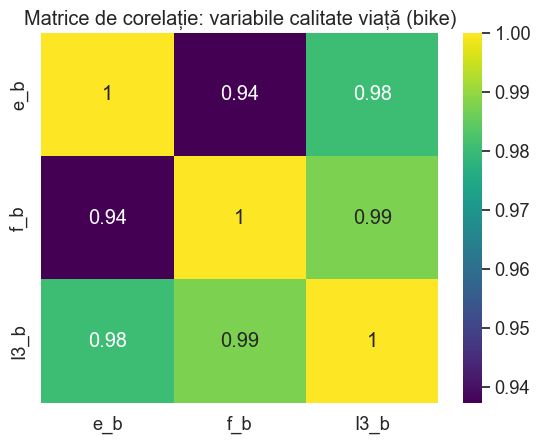

In [152]:
# Walk
corr_life = df[['e_f', 'f_f', 'I3']].corr()
sns.heatmap(corr_life, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile calitate viață (walk)")
plt.show()

# Bike
corr_life_bike = df[['e_b', 'f_b', 'I3_b']].corr()
sns.heatmap(corr_life_bike, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile calitate viață (bike)")
plt.show()



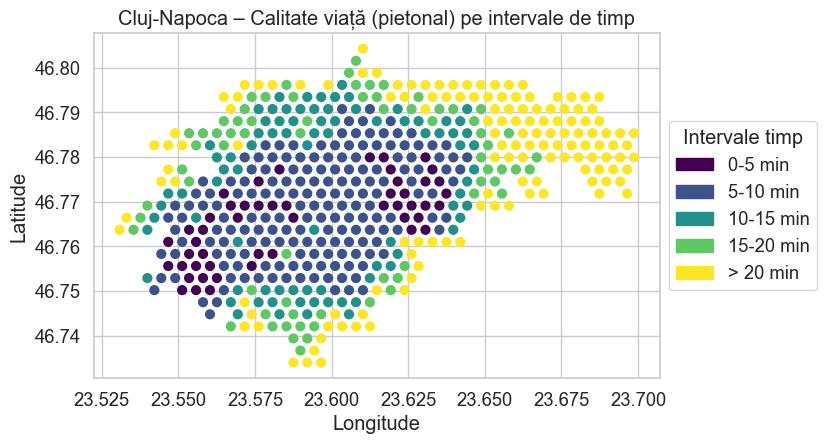


--- Interpretare automată pentru disertație (I3 – pietonal) ---
Figura Z evidențiază distribuția timpilor de acces pietonal pentru indicatorul I3 – Calitatea vieții în Cluj-Napoca.
308 puncte (60.16% din total) se află în intervalul optim de 15 minute.
• 50 puncte (9.77%) se află în zona cu cel mai bun acces (<5 minute).
• 175 puncte (34.18%) beneficiază de acces bun (5–10 minute).
• 83 puncte (16.21%) sunt în zona moderată (10–15 minute).
Restul de 204 puncte (39.84%) se află în afara intervalului recomandat, sugerând dificultăți de acces.
• 69 puncte (13.48%) necesită 15–20 minute.
• 135 puncte (26.37%) depășesc 20 de minute – indicând o calitate scăzută a accesului în aceste zone.


In [180]:
# 1. Calculează indicele I3 (calitate viață) pentru mers pietonal
df['I3'] = df[['e_f', 'f_f']].mean(axis=1)

# 2. Clasificare pe intervale de timp
df['I3_class'] = df['I3'].apply(classify_accessibility).astype(time_class_type)

# 3. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 4. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I3_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Calitate viață (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 5. Interpretare pentru disertație
print("\n--- Interpretare automată pentru disertație (I3 – pietonal) ---")

total_points_i3 = len(gdf)
counts_i3 = gdf['I3_class'].value_counts().sort_index()
percentages_i3 = counts_i3 / total_points_i3 * 100

within_15_i3 = counts_i3.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_i3 = within_15_i3 / total_points_i3 * 100
outside_15_i3 = total_points_i3 - within_15_i3
outside_15_pct_i3 = 100 - within_15_pct_i3

print(f"Figura Z evidențiază distribuția timpilor de acces pietonal pentru indicatorul I3 – Calitatea vieții în Cluj-Napoca.")
print(f"{within_15_i3} puncte ({within_15_pct_i3:.2f}% din total) se află în intervalul optim de 15 minute.")

if '0-5 min' in counts_i3:
    print(f"• {counts_i3['0-5 min']} puncte ({percentages_i3['0-5 min']:.2f}%) se află în zona cu cel mai bun acces (<5 minute).")
if '5-10 min' in counts_i3:
    print(f"• {counts_i3['5-10 min']} puncte ({percentages_i3['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_i3:
    print(f"• {counts_i3['10-15 min']} puncte ({percentages_i3['10-15 min']:.2f}%) sunt în zona moderată (10–15 minute).")

if '15-20 min' in counts_i3 or '> 20 min' in counts_i3:
    print(f"Restul de {outside_15_i3} puncte ({outside_15_pct_i3:.2f}%) se află în afara intervalului recomandat, sugerând dificultăți de acces.")

if '15-20 min' in counts_i3:
    print(f"• {counts_i3['15-20 min']} puncte ({percentages_i3['15-20 min']:.2f}%) necesită 15–20 minute.")
if '> 20 min' in counts_i3:
    print(f"• {counts_i3['> 20 min']} puncte ({percentages_i3['> 20 min']:.2f}%) depășesc 20 de minute – indicând o calitate scăzută a accesului în aceste zone.")



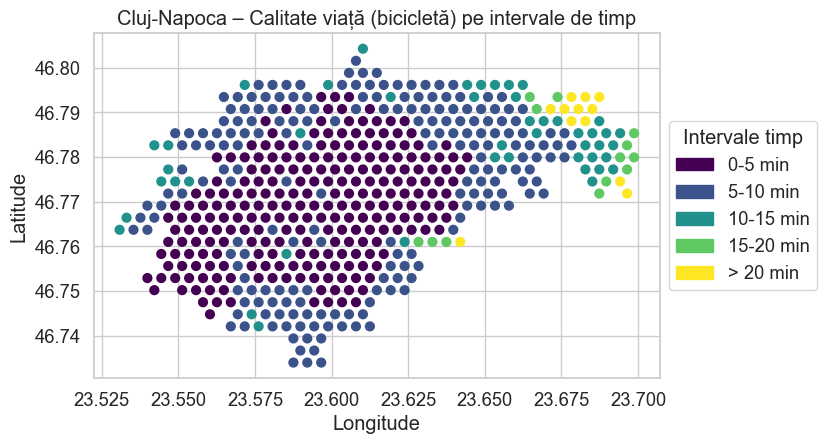


--- Interpretare automată pentru disertație (I3 – bicicletă) ---
Figura X prezintă distribuția accesului cu bicicleta pentru indicatorul I3 – Calitatea vieții în Cluj-Napoca.
487 puncte (95.12% din total) se află în intervalul optim de 15 minute cu bicicleta.
• 240 puncte (46.88%) beneficiază de acces excelent (sub 5 minute).
• 201 puncte (39.26%) au acces bun (5–10 minute).
• 46 puncte (8.98%) sunt într-o zonă de accesibilitate moderată (10–15 minute).
Restul de 25 puncte (4.88%) depășesc pragul de 15 minute, indicând un acces deficitar la facilități esențiale pentru calitatea vieții.
• 13 puncte (2.54%) necesită între 15–20 minute de deplasare.
• 12 puncte (2.34%) depășesc 20 de minute – indicând probleme de echitate în distribuția serviciilor urbane.


In [196]:
# 1. Calculează indicele I3_b (acces cu bicicleta la servicii relevante pentru calitatea vieții)
df['I3_b'] = df[['e_b', 'f_b']].mean(axis=1)

# 2. Clasificare pe intervale de timp
df['I3_b_class'] = df['I3_b'].apply(classify_accessibility).astype(time_class_type)

# 3. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 4. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I3_b_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Calitate viață (bicicletă) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 5. Interpretare automată pentru disertație
print("\n--- Interpretare automată pentru disertație (I3 – bicicletă) ---")

total_points_i3b = len(gdf)
counts_i3b = gdf['I3_b_class'].value_counts().sort_index()
percentages_i3b = counts_i3b / total_points_i3b * 100

within_15_i3b = counts_i3b.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_i3b = within_15_i3b / total_points_i3b * 100
outside_15_i3b = total_points_i3b - within_15_i3b
outside_15_pct_i3b = 100 - within_15_pct_i3b

print(f"Figura X prezintă distribuția accesului cu bicicleta pentru indicatorul I3 – Calitatea vieții în Cluj-Napoca.")
print(f"{within_15_i3b} puncte ({within_15_pct_i3b:.2f}% din total) se află în intervalul optim de 15 minute cu bicicleta.")

if '0-5 min' in counts_i3b:
    print(f"• {counts_i3b['0-5 min']} puncte ({percentages_i3b['0-5 min']:.2f}%) beneficiază de acces excelent (sub 5 minute).")
if '5-10 min' in counts_i3b:
    print(f"• {counts_i3b['5-10 min']} puncte ({percentages_i3b['5-10 min']:.2f}%) au acces bun (5–10 minute).")
if '10-15 min' in counts_i3b:
    print(f"• {counts_i3b['10-15 min']} puncte ({percentages_i3b['10-15 min']:.2f}%) sunt într-o zonă de accesibilitate moderată (10–15 minute).")

if '15-20 min' in counts_i3b or '> 20 min' in counts_i3b:
    print(f"Restul de {outside_15_i3b} puncte ({outside_15_pct_i3b:.2f}%) depășesc pragul de 15 minute, indicând un acces deficitar la facilități esențiale pentru calitatea vieții.")

if '15-20 min' in counts_i3b:
    print(f"• {counts_i3b['15-20 min']} puncte ({percentages_i3b['15-20 min']:.2f}%) necesită între 15–20 minute de deplasare.")
if '> 20 min' in counts_i3b:
    print(f"• {counts_i3b['> 20 min']} puncte ({percentages_i3b['> 20 min']:.2f}%) depășesc 20 de minute – indicând probleme de echitate în distribuția serviciilor urbane.")


In [156]:
# Densitate în persoane/ha
df['density_ha'] = df['density'] / 100


# Statistici densitate pe clase (walk)
pop_density_stats_foot = df.groupby('I3_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# Statistici densitate pe clase (bike)
pop_density_stats_bike = df.groupby('I3_b_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# Îmbinare tabel
all_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
table = pd.DataFrame({'Time class': all_classes})

table = table.merge(pop_density_stats_foot, left_on='Time class', right_on='I3_class', how='left')
table = table.merge(pop_density_stats_bike, left_on='Time class', right_on='I3_b_class', how='left', suffixes=(' (Foot)', ' (Bike)'))

table = table[['Time class',
               'Mean_density (Foot)', 'Std_density (Foot)', 'Min_density (Foot)', 'Max_density (Foot)',
               'Mean_density (Bike)', 'Std_density (Bike)', 'Min_density (Bike)', 'Max_density (Bike)']]

# Rotunjire la 2 zecimale
table = table.round(2)

print("\nTabel statistici pentru I3 (calitatea vieții), walk vs bike:\n")
print(table)



Tabel statistici pentru I3 (calitatea vieții), walk vs bike:

  Time class  Mean_density (Foot)  Std_density (Foot)  Min_density (Foot)  \
0    0-5 min                37.46               13.13                6.84   
1   5-10 min                37.52               13.17                0.00   
2  10-15 min                26.06               15.31                0.00   
3  15-20 min                19.48               14.29                0.00   
4   > 20 min                10.26                9.26                0.00   

   Max_density (Foot)  Mean_density (Bike)  Std_density (Bike)  \
0               52.47                36.70               13.42   
1               52.64                18.82               14.94   
2               48.59                12.22               10.51   
3               48.68                 8.95                9.38   
4               36.74                 5.03                2.91   

   Min_density (Bike)  Max_density (Bike)  
0                 0.0            

C:\Users\rober\AppData\Local\Temp\ipykernel_31908\4293680632.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pop_density_stats_foot = df.groupby('I3_class')['density_ha'].agg(
C:\Users\rober\AppData\Local\Temp\ipykernel_31908\4293680632.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pop_density_stats_bike = df.groupby('I3_b_class')['density_ha'].agg(


# **Al patrulea Indice calculat**

Statistici descriptive I4 (walk):
 count    512.00000
mean      14.11791
std       11.07148
min        1.08500
25%        6.11500
50%       11.27000
75%       19.16250
max       72.91500
Name: I4, dtype: float64
Statistici descriptive I4 (bike):
 count    512.000000
mean       5.844502
std        3.997652
min        0.845000
25%        3.072500
50%        4.927500
75%        7.530000
max       26.705000
Name: I4_b, dtype: float64


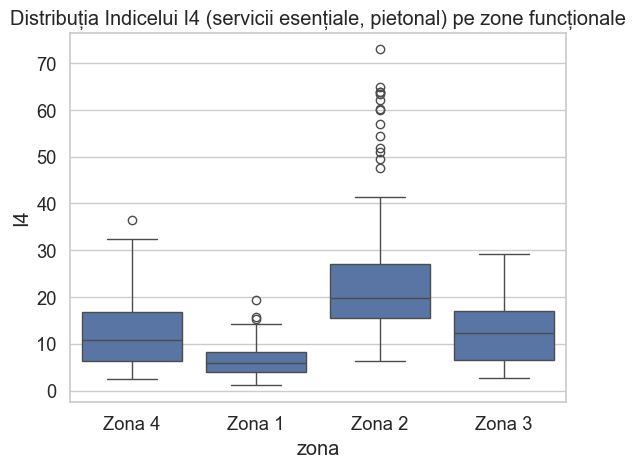

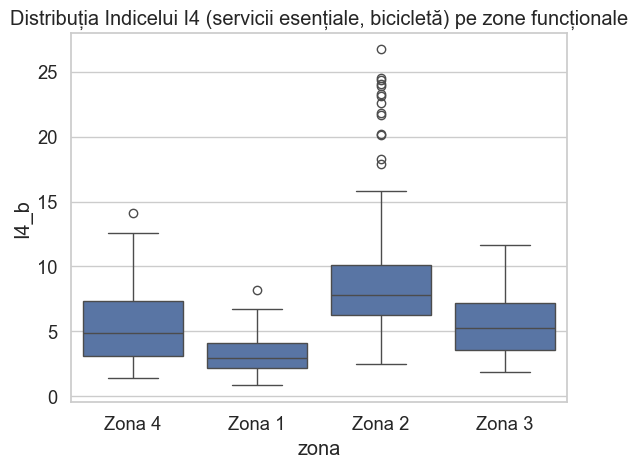

In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('output_fix_with_zones.xlsx')

# Calculează indicii I4 pentru walk și bike
df['I4'] = df[['g_f', 'h_f']].mean(axis=1)
df['I4_b'] = df[['g_b', 'h_b']].mean(axis=1)

# Statistici descriptive
print("Statistici descriptive I4 (walk):\n", df['I4'].describe())
print("Statistici descriptive I4 (bike):\n", df['I4_b'].describe())

# Boxplot distribuție pe zone funcționale (walk)
sns.boxplot(x='zona', y='I4', data=df)
plt.title("Distribuția Indicelui I4 (servicii esențiale, pietonal) pe zone funcționale")
plt.show()

# Boxplot distribuție pe zone funcționale (bike)
sns.boxplot(x='zona', y='I4_b', data=df)
plt.title("Distribuția Indicelui I4 (servicii esențiale, bicicletă) pe zone funcționale")
plt.show()


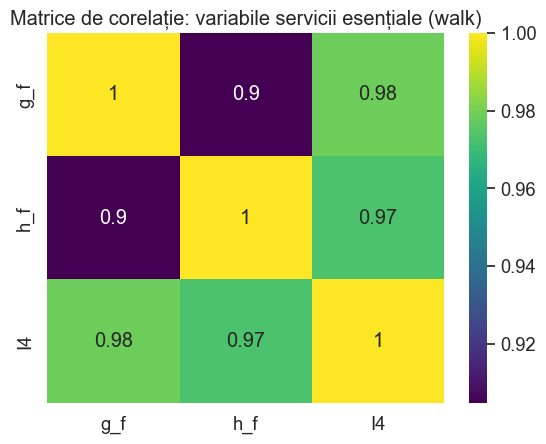

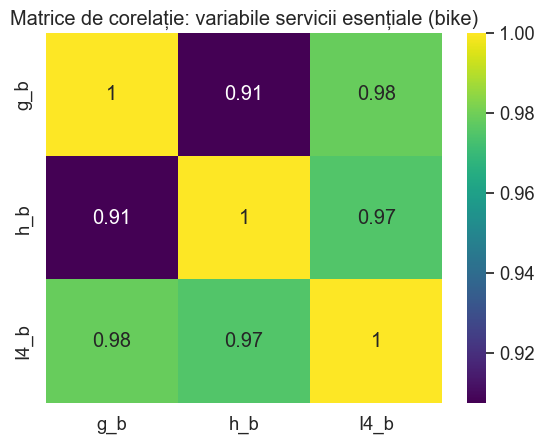

In [159]:
# Walk
corr_services = df[['g_f', 'h_f', 'I4']].corr()
sns.heatmap(corr_services, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile servicii esențiale (walk)")
plt.show()

# Bike
corr_services_bike = df[['g_b', 'h_b', 'I4_b']].corr()
sns.heatmap(corr_services_bike, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile servicii esențiale (bike)")
plt.show()



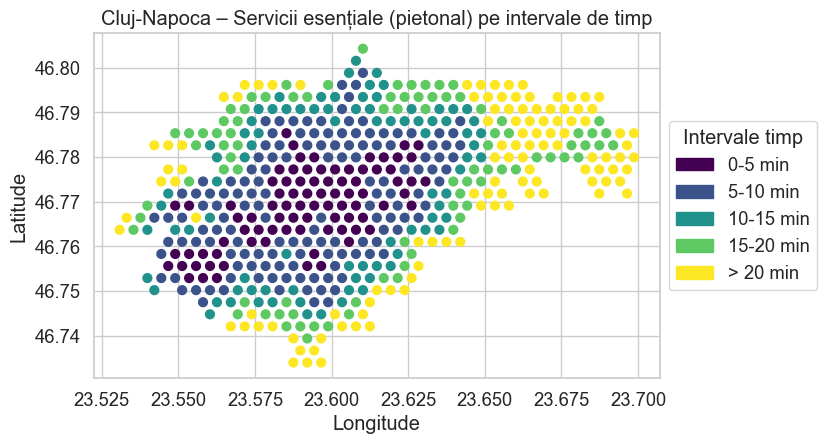


--- Interpretare automată pentru disertație (I4 – pietonal) ---
Figura Z+1 ilustrează distribuția timpilor de acces pietonal pentru indicatorul I4 – Servicii esențiale în Cluj-Napoca.
313 puncte (61.13% din total) se află în intervalul optim de 15 minute.
• 85 puncte (16.60%) se află în zona cu cel mai bun acces (<5 minute).
• 142 puncte (27.73%) beneficiază de acces bun (5–10 minute).
• 86 puncte (16.80%) sunt în zona moderată (10–15 minute).
Restul de 199 puncte (38.87%) depășesc intervalul recomandat de 15 minute, indicând zone cu acces limitat.
• 87 puncte (16.99%) necesită 15–20 minute.
• 112 puncte (21.88%) depășesc 20 de minute – evidențiind lipsa proximității la servicii esențiale în acele zone.


In [197]:
# 1. Calculează indicele I4 (acces servicii esențiale) pentru mers pietonal
df['I4'] = df[['g_f', 'h_f']].mean(axis=1)

# 2. Clasificare pe intervale de timp
df['I4_class'] = df['I4'].apply(classify_accessibility).astype(time_class_type)

# 3. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 4. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I4_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Servicii esențiale (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 5. Interpretare automată pentru disertație
print("\n--- Interpretare automată pentru disertație (I4 – pietonal) ---")

total_points_i4 = len(gdf)
counts_i4 = gdf['I4_class'].value_counts().sort_index()
percentages_i4 = counts_i4 / total_points_i4 * 100

within_15_i4 = counts_i4.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_i4 = within_15_i4 / total_points_i4 * 100
outside_15_i4 = total_points_i4 - within_15_i4
outside_15_pct_i4 = 100 - within_15_pct_i4

print(f"Figura Z+1 ilustrează distribuția timpilor de acces pietonal pentru indicatorul I4 – Servicii esențiale în Cluj-Napoca.")
print(f"{within_15_i4} puncte ({within_15_pct_i4:.2f}% din total) se află în intervalul optim de 15 minute.")

if '0-5 min' in counts_i4:
    print(f"• {counts_i4['0-5 min']} puncte ({percentages_i4['0-5 min']:.2f}%) se află în zona cu cel mai bun acces (<5 minute).")
if '5-10 min' in counts_i4:
    print(f"• {counts_i4['5-10 min']} puncte ({percentages_i4['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_i4:
    print(f"• {counts_i4['10-15 min']} puncte ({percentages_i4['10-15 min']:.2f}%) sunt în zona moderată (10–15 minute).")

if '15-20 min' in counts_i4 or '> 20 min' in counts_i4:
    print(f"Restul de {outside_15_i4} puncte ({outside_15_pct_i4:.2f}%) depășesc intervalul recomandat de 15 minute, indicând zone cu acces limitat.")

if '15-20 min' in counts_i4:
    print(f"• {counts_i4['15-20 min']} puncte ({percentages_i4['15-20 min']:.2f}%) necesită 15–20 minute.")
if '> 20 min' in counts_i4:
    print(f"• {counts_i4['> 20 min']} puncte ({percentages_i4['> 20 min']:.2f}%) depășesc 20 de minute – evidențiind lipsa proximității la servicii esențiale în acele zone.")


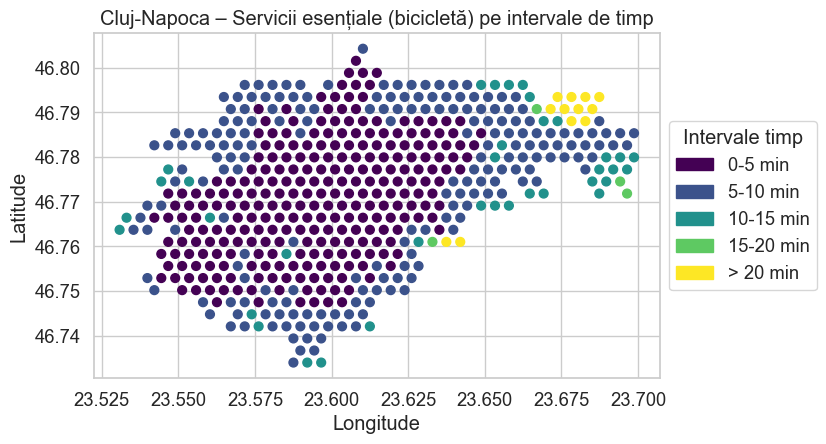


--- Interpretare automată pentru disertație (I4_b – bicicletă) ---
Figura Z+2 ilustrează distribuția timpilor de acces cu bicicleta pentru indicatorul I4 – Servicii esențiale în Cluj-Napoca.
496 puncte (96.88% din total) se află în intervalul optim de 15 minute.
• 262 puncte (51.17%) se află în zona cu cel mai bun acces (<5 minute).
• 198 puncte (38.67%) beneficiază de acces bun (5–10 minute).
• 36 puncte (7.03%) sunt în zona moderată (10–15 minute).
Restul de 16 puncte (3.12%) depășesc intervalul recomandat de 15 minute, indicând zone cu acces limitat.
• 4 puncte (0.78%) necesită 15–20 minute.
• 12 puncte (2.34%) depășesc 20 de minute – evidențiind lipsa proximității la servicii esențiale în acele zone.


In [199]:
# 1. Calculează indicele I4_b (acces servicii esențiale) pentru bicicletă
df['I4_b'] = df[['g_b', 'h_b']].mean(axis=1)

# 2. Clasificare pe intervale de timp
df['I4_b_class'] = df['I4_b'].apply(classify_accessibility).astype(time_class_type)

# 3. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 4. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I4_b_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Servicii esențiale (bicicletă) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 5. Interpretare automată pentru disertație
print("\n--- Interpretare automată pentru disertație (I4_b – bicicletă) ---")

total_points_i4b = len(gdf)
counts_i4b = gdf['I4_b_class'].value_counts().sort_index()
percentages_i4b = counts_i4b / total_points_i4b * 100

within_15_i4b = counts_i4b.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_i4b = within_15_i4b / total_points_i4b * 100
outside_15_i4b = total_points_i4b - within_15_i4b
outside_15_pct_i4b = 100 - within_15_pct_i4b

print(f"Figura Z+2 ilustrează distribuția timpilor de acces cu bicicleta pentru indicatorul I4 – Servicii esențiale în Cluj-Napoca.")
print(f"{within_15_i4b} puncte ({within_15_pct_i4b:.2f}% din total) se află în intervalul optim de 15 minute.")

if '0-5 min' in counts_i4b:
    print(f"• {counts_i4b['0-5 min']} puncte ({percentages_i4b['0-5 min']:.2f}%) se află în zona cu cel mai bun acces (<5 minute).")
if '5-10 min' in counts_i4b:
    print(f"• {counts_i4b['5-10 min']} puncte ({percentages_i4b['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_i4b:
    print(f"• {counts_i4b['10-15 min']} puncte ({percentages_i4b['10-15 min']:.2f}%) sunt în zona moderată (10–15 minute).")

if '15-20 min' in counts_i4b or '> 20 min' in counts_i4b:
    print(f"Restul de {outside_15_i4b} puncte ({outside_15_pct_i4b:.2f}%) depășesc intervalul recomandat de 15 minute, indicând zone cu acces limitat.")

if '15-20 min' in counts_i4b:
    print(f"• {counts_i4b['15-20 min']} puncte ({percentages_i4b['15-20 min']:.2f}%) necesită 15–20 minute.")
if '> 20 min' in counts_i4b:
    print(f"• {counts_i4b['> 20 min']} puncte ({percentages_i4b['> 20 min']:.2f}%) depășesc 20 de minute – evidențiind lipsa proximității la servicii esențiale în acele zone.")



In [215]:
import pandas as pd

# 1. Funcția de clasificare
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

# 2. Categorii ordonate
from pandas.api.types import CategoricalDtype
time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# 3. Calculul indicelui I4 și I4_b
df['I4'] = df[['g_f', 'h_f']].mean(axis=1)        # Pe jos
df['I4_b'] = df[['g_b', 'h_b']].mean(axis=1)      # Bicicletă

# 4. Clasificare în clase de timp
df['I4_class'] = df['I4'].apply(classify_accessibility).astype(time_class_type)
df['I4_b_class'] = df['I4_b'].apply(classify_accessibility).astype(time_class_type)

# 5. Calcul densitate în oameni/hectar
df['density_ha'] = df['density'] / 100  # Dacă era inițial în oameni/km2

# 6. Grupare și statistici – WALK
pop_density_stats_foot = df.groupby('I4_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# 7. Grupare și statistici – BIKE
pop_density_stats_bike = df.groupby('I4_b_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# 8. Combinare în tabel final
all_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
table = pd.DataFrame({'Time class': all_classes})

table = table.merge(pop_density_stats_foot, left_on='Time class', right_on='I4_class', how='left')
table = table.merge(pop_density_stats_bike, left_on='Time class', right_on='I4_b_class', how='left', suffixes=(' (Foot)', ' (Bike)'))

table = table[['Time class',
               'Mean_density (Foot)', 'Std_density (Foot)', 'Min_density (Foot)', 'Max_density (Foot)',
               'Mean_density (Bike)', 'Std_density (Bike)', 'Min_density (Bike)', 'Max_density (Bike)']]

# 9. Rotunjire
table = table.round(2)

# 10. Afișare tabel
print("\nTabel statistici pentru I4 (servicii esențiale), walk vs bike:\n")
print(table)



Tabel statistici pentru I4 (servicii esențiale), walk vs bike:

  Time class  Mean_density (Foot)  Std_density (Foot)  Min_density (Foot)  \
0    0-5 min                45.60                7.64               18.12   
1   5-10 min                36.09               11.12                7.23   
2  10-15 min                24.46               13.35                0.00   
3  15-20 min                14.34               10.86                0.00   
4   > 20 min                 8.72                9.10                0.00   

   Max_density (Foot)  Mean_density (Bike)  Std_density (Bike)  \
0               52.64                37.58               12.52   
1               51.88                15.49               12.40   
2               50.25                 9.80               10.44   
3               46.92                 4.25                4.17   
4               39.58                 3.92                2.92   

   Min_density (Bike)  Max_density (Bike)  
0                2.46          

C:\Users\rober\AppData\Local\Temp\ipykernel_31908\2420478169.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pop_density_stats_foot = df.groupby('I4_class')['density_ha'].agg(
C:\Users\rober\AppData\Local\Temp\ipykernel_31908\2420478169.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pop_density_stats_bike = df.groupby('I4_b_class')['density_ha'].agg(


# **Al cincilea Indice calculat**

Statistici descriptive I5 (walk):
 count    512.000000
mean      10.212119
std        9.229577
min        0.920000
25%        4.912500
50%        7.317500
75%       12.300000
max       69.505000
Name: I5, dtype: float64
Statistici descriptive I5 (bike):
 count    512.000000
mean       4.291719
std        3.419870
min        0.790000
25%        2.351250
50%        3.245000
75%        4.992500
max       25.145000
Name: I5_b, dtype: float64


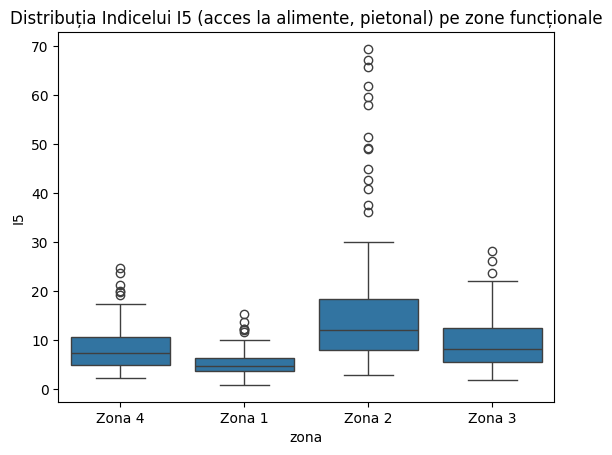

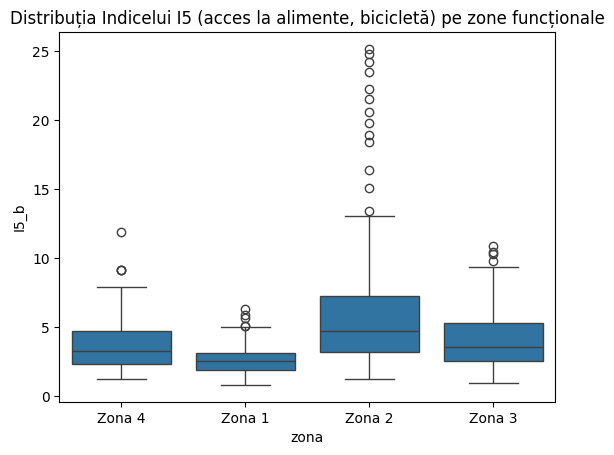

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('output_fix_with_zones.xlsx')

# Calculează indicii I5 pentru walk și bike
df['I5'] = df[['i_f', 'l_f']].mean(axis=1)
df['I5_b'] = df[['i_b', 'l_b']].mean(axis=1)

# Statistici descriptive
print("Statistici descriptive I5 (walk):\n", df['I5'].describe())
print("Statistici descriptive I5 (bike):\n", df['I5_b'].describe())

# Boxplot distribuție pe zone funcționale (walk)
sns.boxplot(x='zona', y='I5', data=df)
plt.title("Distribuția Indicelui I5 (acces la alimente, pietonal) pe zone funcționale")
plt.show()

# Boxplot distribuție pe zone funcționale (bike)
sns.boxplot(x='zona', y='I5_b', data=df)
plt.title("Distribuția Indicelui I5 (acces la alimente, bicicletă) pe zone funcționale")
plt.show()


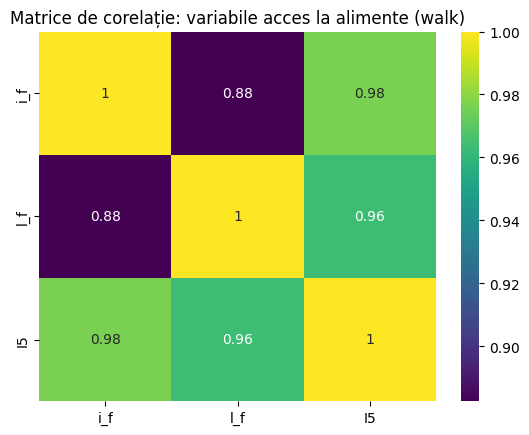

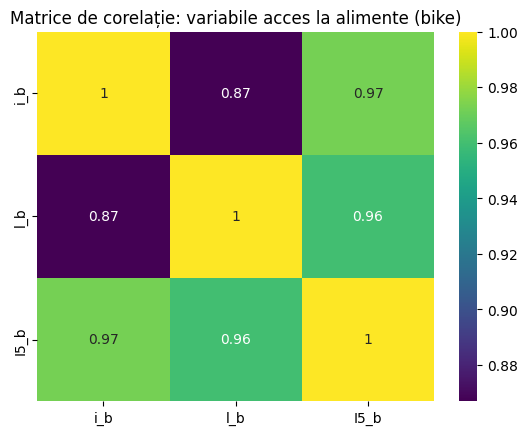

In [6]:
# Walk
corr_food = df[['i_f', 'l_f', 'I5']].corr()
sns.heatmap(corr_food, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile acces la alimente (walk)")
plt.show()

# Bike
corr_food_bike = df[['i_b', 'l_b', 'I5_b']].corr()
sns.heatmap(corr_food_bike, annot=True, cmap="viridis")
plt.title("Matrice de corelație: variabile acces la alimente (bike)")
plt.show()


In [7]:
# 1. Calculare I5 ca medie între i_f și l_f (acces la alimente – pietonal)
df['I5'] = df[['i_f', 'l_f']].mean(axis=1)

# 2. Clasificare pe intervale de timp pentru I5
df['I5_class'] = df['I5'].apply(classify_accessibility).astype(time_class_type)

# 3. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 4. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I5_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces la alimente (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

import geopandas as gpd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# 1. Funcție de clasificare a timpilor de acces
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

# 2. Definire categorii și tipuri
time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# 3. Clasificare pe intervale de timp pentru I5 (acces la alimente – pietonal)
df['I5_class'] = df['I5'].apply(classify_accessibility).astype(time_class_type)

# 4. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 5. Paletă de culori personalizată
cmap = plt.get_cmap('viridis', 5)
custom_colors = [cmap(i / 4) for i in range(5)]

# 6. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I5_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces la alimente (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 7. Interpretare automată pentru disertație
print("\n--- Interpretare automată pentru disertație (I5 – pietonal) ---")

total_points_i5 = len(gdf)
counts_i5 = gdf['I5_class'].value_counts().sort_index()
percentages_i5 = counts_i5 / total_points_i5 * 100

within_15_i5 = counts_i5.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_i5 = within_15_i5 / total_points_i5 * 100
outside_15_i5 = total_points_i5 - within_15_i5
outside_15_pct_i5 = 100 - within_15_pct_i5

print(f"Figura Z+3 reflectă distribuția timpilor de acces pietonal pentru indicatorul I5 – Acces la alimente în Cluj-Napoca.")
print(f"{within_15_i5} puncte ({within_15_pct_i5:.2f}% din total) se află în intervalul optim de 15 minute.")

if '0-5 min' in counts_i5:
    print(f"• {counts_i5['0-5 min']} puncte ({percentages_i5['0-5 min']:.2f}%) se află în zona cu cel mai bun acces (<5 minute).")
if '5-10 min' in counts_i5:
    print(f"• {counts_i5['5-10 min']} puncte ({percentages_i5['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_i5:
    print(f"• {counts_i5['10-15 min']} puncte ({percentages_i5['10-15 min']:.2f}%) sunt în zona moderată (10–15 minute).")

if '15-20 min' in counts_i5 or '> 20 min' in counts_i5:
    print(f"Restul de {outside_15_i5} puncte ({outside_15_pct_i5:.2f}%) depășesc intervalul recomandat de 15 minute, sugerând dificultăți în accesul la alimente.")

if '15-20 min' in counts_i5:
    print(f"• {counts_i5['15-20 min']} puncte ({percentages_i5['15-20 min']:.2f}%) necesită 15–20 minute.")
if '> 20 min' in counts_i5:
    print(f"• {counts_i5['> 20 min']} puncte ({percentages_i5['> 20 min']:.2f}%) depășesc 20 de minute – indicând lipsa facilităților alimentare în proximitate.")



NameError: name 'classify_accessibility' is not defined

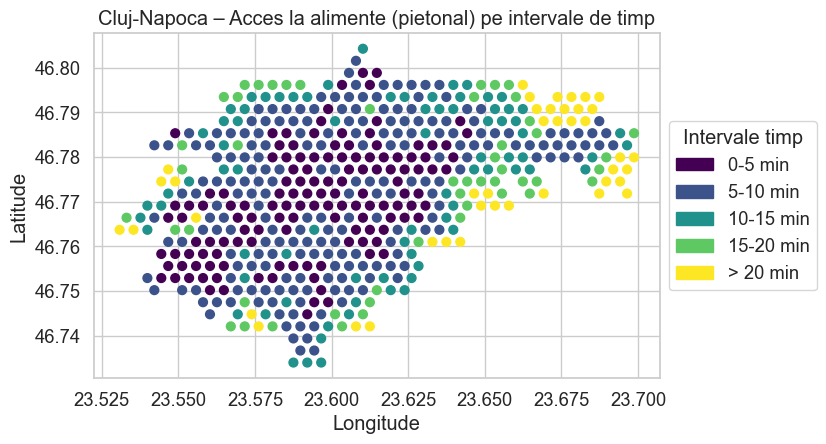

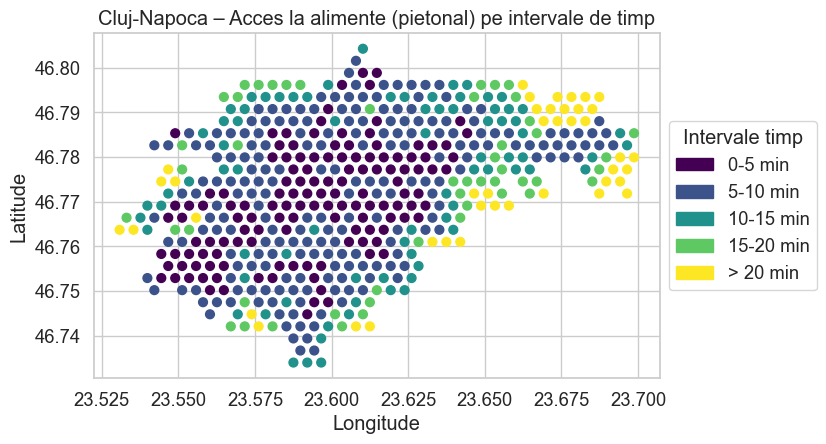


--- Interpretare automată pentru disertație (I5 – pietonal) ---
Figura Z+3 reflectă distribuția timpilor de acces pietonal pentru indicatorul I5 – Acces la alimente în Cluj-Napoca.
421 puncte (82.23% din total) se află în intervalul optim de 15 minute.
• 134 puncte (26.17%) se află în zona cu cel mai bun acces (<5 minute).
• 208 puncte (40.62%) beneficiază de acces bun (5–10 minute).
• 79 puncte (15.43%) sunt în zona moderată (10–15 minute).
Restul de 91 puncte (17.77%) depășesc intervalul recomandat de 15 minute, sugerând dificultăți în accesul la alimente.
• 49 puncte (9.57%) necesită 15–20 minute.
• 42 puncte (8.20%) depășesc 20 de minute – indicând lipsa facilităților alimentare în proximitate.


In [ ]:
# 1. Calculare I5 ca medie între i_f și l_f (acces la alimente – pietonal)
df['I5'] = df[['i_f', 'l_f']].mean(axis=1)

# 2. Clasificare pe intervale de timp pentru I5
df['I5_class'] = df['I5'].apply(classify_accessibility).astype(time_class_type)

# 3. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 4. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I5_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces la alimente (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

import geopandas as gpd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# 1. Funcție de clasificare a timpilor de acces
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

# 2. Definire categorii și tipuri
time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# 3. Clasificare pe intervale de timp pentru I5 (acces la alimente – pietonal)
df['I5_class'] = df['I5'].apply(classify_accessibility).astype(time_class_type)

# 4. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 5. Paletă de culori personalizată
cmap = plt.get_cmap('viridis', 5)
custom_colors = [cmap(i / 4) for i in range(5)]

# 6. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I5_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces la alimente (pietonal) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 7. Interpretare automată pentru disertație
print("\n--- Interpretare automată pentru disertație (I5 – pietonal) ---")

total_points_i5 = len(gdf)
counts_i5 = gdf['I5_class'].value_counts().sort_index()
percentages_i5 = counts_i5 / total_points_i5 * 100

within_15_i5 = counts_i5.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_i5 = within_15_i5 / total_points_i5 * 100
outside_15_i5 = total_points_i5 - within_15_i5
outside_15_pct_i5 = 100 - within_15_pct_i5

print(f"Figura Z+3 reflectă distribuția timpilor de acces pietonal pentru indicatorul I5 – Acces la alimente în Cluj-Napoca.")
print(f"{within_15_i5} puncte ({within_15_pct_i5:.2f}% din total) se află în intervalul optim de 15 minute.")

if '0-5 min' in counts_i5:
    print(f"• {counts_i5['0-5 min']} puncte ({percentages_i5['0-5 min']:.2f}%) se află în zona cu cel mai bun acces (<5 minute).")
if '5-10 min' in counts_i5:
    print(f"• {counts_i5['5-10 min']} puncte ({percentages_i5['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_i5:
    print(f"• {counts_i5['10-15 min']} puncte ({percentages_i5['10-15 min']:.2f}%) sunt în zona moderată (10–15 minute).")

if '15-20 min' in counts_i5 or '> 20 min' in counts_i5:
    print(f"Restul de {outside_15_i5} puncte ({outside_15_pct_i5:.2f}%) depășesc intervalul recomandat de 15 minute, sugerând dificultăți în accesul la alimente.")

if '15-20 min' in counts_i5:
    print(f"• {counts_i5['15-20 min']} puncte ({percentages_i5['15-20 min']:.2f}%) necesită 15–20 minute.")
if '> 20 min' in counts_i5:
    print(f"• {counts_i5['> 20 min']} puncte ({percentages_i5['> 20 min']:.2f}%) depășesc 20 de minute – indicând lipsa facilităților alimentare în proximitate.")



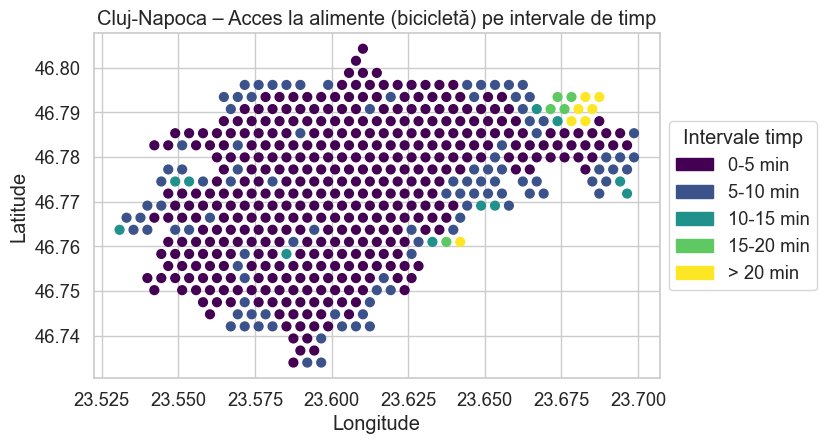


--- Interpretare automată pentru disertație (I5 – bicicletă) ---
Figura Z+4 reflectă distribuția timpilor de acces cu bicicleta pentru indicatorul I5 – Acces la alimente în Cluj-Napoca.
500 puncte (97.66% din total) se află în intervalul optim de 15 minute.
• 386 puncte (75.39%) se află în zona cu cel mai bun acces (<5 minute).
• 103 puncte (20.12%) beneficiază de acces bun (5–10 minute).
• 11 puncte (2.15%) sunt în zona moderată (10–15 minute).
Restul de 12 puncte (2.34%) depășesc intervalul recomandat de 15 minute, sugerând dificultăți în accesul la facilități alimentare.
• 5 puncte (0.98%) necesită 15–20 minute.
• 7 puncte (1.37%) depășesc 20 de minute – indicând lipsa proximității la puncte de aprovizionare.


In [212]:
import geopandas as gpd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# 1. Funcție de clasificare a timpilor de acces
def classify_accessibility(value):
    if value <= 5:
        return '0-5 min'
    elif value <= 10:
        return '5-10 min'
    elif value <= 15:
        return '10-15 min'
    elif value <= 20:
        return '15-20 min'
    else:
        return '> 20 min'

# 2. Definire categorii și tipuri
time_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
time_class_type = CategoricalDtype(categories=time_classes, ordered=True)

# 3. Calcul și clasificare pentru I5_b (acces la alimente – bicicletă)
df['I5_b'] = df[['i_b', 'l_b']].mean(axis=1)
df['I5_b_class'] = df['I5_b'].apply(classify_accessibility).astype(time_class_type)

# 4. Convertire în GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']), crs="EPSG:4326")

# 5. Paletă de culori personalizată
cmap = plt.get_cmap('viridis', 5)
custom_colors = [cmap(i / 4) for i in range(5)]

# 6. Hartă
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='I5_b_class', cmap=mcolors.ListedColormap(custom_colors),
         legend=False, categorical=True, ax=ax, markersize=40)
handles = [mpatches.Patch(color=custom_colors[i], label=tc) for i, tc in enumerate(time_classes)]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Intervale timp")
plt.title('Cluj-Napoca – Acces la alimente (bicicletă) pe intervale de timp')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 7. Interpretare automată pentru disertație
print("\n--- Interpretare automată pentru disertație (I5 – bicicletă) ---")

total_points_i5b = len(gdf)
counts_i5b = gdf['I5_b_class'].value_counts().sort_index()
percentages_i5b = counts_i5b / total_points_i5b * 100

within_15_i5b = counts_i5b.loc[['0-5 min', '5-10 min', '10-15 min']].sum()
within_15_pct_i5b = within_15_i5b / total_points_i5b * 100
outside_15_i5b = total_points_i5b - within_15_i5b
outside_15_pct_i5b = 100 - within_15_pct_i5b

print(f"Figura Z+4 reflectă distribuția timpilor de acces cu bicicleta pentru indicatorul I5 – Acces la alimente în Cluj-Napoca.")
print(f"{within_15_i5b} puncte ({within_15_pct_i5b:.2f}% din total) se află în intervalul optim de 15 minute.")

if '0-5 min' in counts_i5b:
    print(f"• {counts_i5b['0-5 min']} puncte ({percentages_i5b['0-5 min']:.2f}%) se află în zona cu cel mai bun acces (<5 minute).")
if '5-10 min' in counts_i5b:
    print(f"• {counts_i5b['5-10 min']} puncte ({percentages_i5b['5-10 min']:.2f}%) beneficiază de acces bun (5–10 minute).")
if '10-15 min' in counts_i5b:
    print(f"• {counts_i5b['10-15 min']} puncte ({percentages_i5b['10-15 min']:.2f}%) sunt în zona moderată (10–15 minute).")

if '15-20 min' in counts_i5b or '> 20 min' in counts_i5b:
    print(f"Restul de {outside_15_i5b} puncte ({outside_15_pct_i5b:.2f}%) depășesc intervalul recomandat de 15 minute, sugerând dificultăți în accesul la facilități alimentare.")

if '15-20 min' in counts_i5b:
    print(f"• {counts_i5b['15-20 min']} puncte ({percentages_i5b['15-20 min']:.2f}%) necesită 15–20 minute.")
if '> 20 min' in counts_i5b:
    print(f"• {counts_i5b['> 20 min']} puncte ({percentages_i5b['> 20 min']:.2f}%) depășesc 20 de minute – indicând lipsa proximității la puncte de aprovizionare.")


In [1]:
df['density_ha'] = df['density'] / 10000

# Statistici densitate pe clase (walk)
pop_density_stats_foot = df.groupby('I5_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# Statistici densitate pe clase (bike)
pop_density_stats_bike = df.groupby('I5_b_class')['density_ha'].agg(
    Mean_density='mean',
    Std_density='std',
    Min_density='min',
    Max_density='max'
).reset_index()

# Îmbinare tabel
all_classes = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '> 20 min']
table = pd.DataFrame({'Time class': all_classes})

table = table.merge(pop_density_stats_foot, left_on='Time class', right_on='I5_class', how='left')
table = table.merge(pop_density_stats_bike, left_on='Time class', right_on='I5_b_class', how='left', suffixes=(' (Foot)', ' (Bike)'))

table = table[['Time class',
               'Mean_density (Foot)', 'Std_density (Foot)', 'Min_density (Foot)', 'Max_density (Foot)',
               'Mean_density (Bike)', 'Std_density (Bike)', 'Min_density (Bike)', 'Max_density (Bike)']]

# Rotunjire la 2 zecimale
table = table.round(2)

print("\nTabel statistici pentru I5 (acces la alimente), walk vs bike:\n")
print(table)


NameError: name 'df' is not defined

## Densitatea pe zona


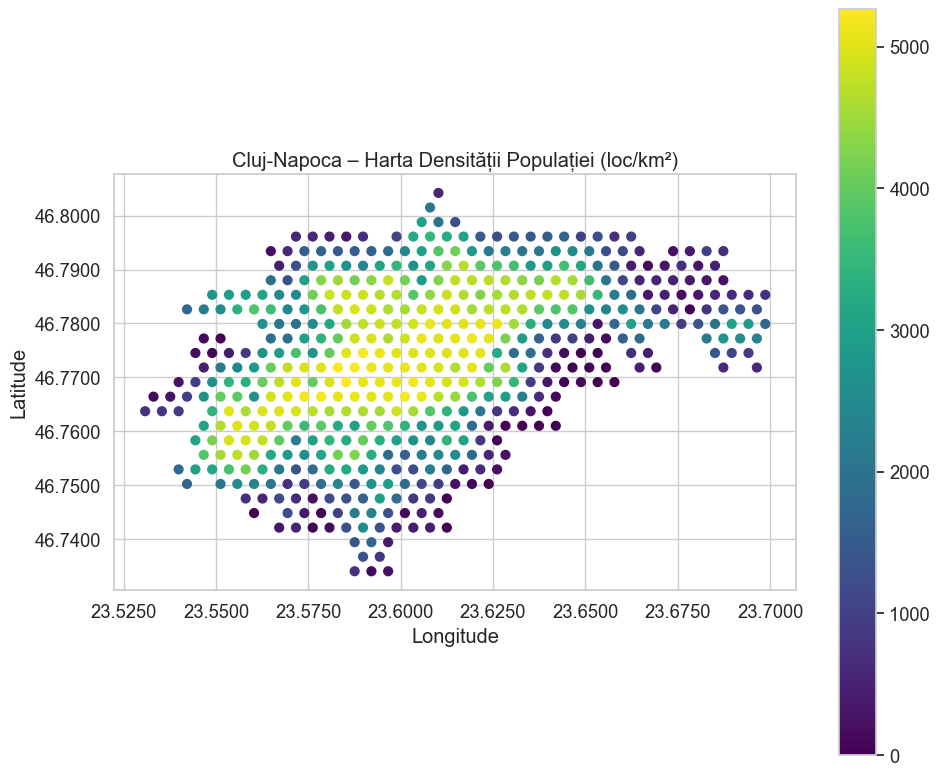

In [232]:
import geopandas as gpd
import shapely.wkt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Convertim stringurile WKT la obiecte shapely
df['geometry'] = df['geometry'].apply(shapely.wkt.loads)

# Creăm GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")

# HARTA DENSITATE POPULAȚIE CLUJ-NAPOCA
fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(
    column='density',
    cmap='viridis',
    legend=True,
    ax=ax,
    markersize=40
)

plt.title('Cluj-Napoca – Harta Densității Populației (loc/km²)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.4f}'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:,.4f}'))

plt.tight_layout()
plt.show()


In [4]:
import numpy as np

# Dacă nu există coloanele, le recalculezi
if 'AAF' not in df.columns or 'AAB' not in df.columns:
    foot_cols = [col for col in df.columns if col.endswith('_f')]
    bike_cols = [col for col in df.columns if col.endswith('_b')]
    df['AAF'] = df[foot_cols].mean(axis=1)
    df['AAB'] = df[bike_cols].mean(axis=1)

# Asigură-te că și gdf conține AAF și AAB
gdf['AAF'] = df['AAF']
gdf['AAB'] = df['AAB']

# Tabel sumar pe zona
tabel_zona = gdf.groupby('zona').agg({
    'density': 'mean',
    'AAF': 'mean',
    'AAB': 'mean'
}).reset_index()

# Rotunjire și redenumire coloane
tabel_zona = tabel_zona.round({'density': 2, 'AAF': 2, 'AAB': 2})
tabel_zona = tabel_zona.rename(columns={
    'zona': 'Zonă',
    'density': 'Densitate populație (loc/km²)',
    'AAF': 'Accesibilitate medie pietonal (min)',
    'AAB': 'Accesibilitate medie bicicletă (min)'
})

print(tabel_zona)

# (Opțional) Salvează în Excel
tabel_zona.to_excel('rezumat_per_zona.xlsx', index=False)


NameError: name 'df' is not defined

In [3]:
# Calculăm densitatea în loc/ha
gdf['density_ha'] = gdf['density'] * 0.01

# Tabel sumar pe zona, densitate în loc/ha
tabel_zona = gdf.groupby('zona').agg({
    'density_ha': 'mean',
    'AAF': 'mean',
    'AAB': 'mean'
}).reset_index()

# Rotunjire și redenumire coloane
tabel_zona = tabel_zona.round({'density_ha': 2, 'AAF': 2, 'AAB': 2})
tabel_zona = tabel_zona.rename(columns={
    'zona': 'Zonă',
    'density_ha': 'Densitate populație (loc/ha)',
    'AAF': 'Accesibilitate medie pietonal (min)',
    'AAB': 'Accesibilitate medie bicicletă (min)'
})

print(tabel_zona)

# (Opțional) Salvează în Excel
tabel_zona.to_excel('rezumat_per_zona.xlsx', index=False)


NameError: name 'gdf' is not defined

Index(['a_f', 'b_f', 'c_f', 'd_f', 'e_f', 'f_f', 'g_f', 'h_f', 'i_f', 'l_f',
       'a_b', 'b_b', 'c_b', 'd_b', 'e_b', 'f_b', 'g_b', 'h_b', 'i_b', 'l_b',
       'radius', 'population', 'centroid_lon', 'centroid_lat', 'area_km2',
       'density', 'geometry', 'index_right', 'name', 'zona'],
      dtype='object')


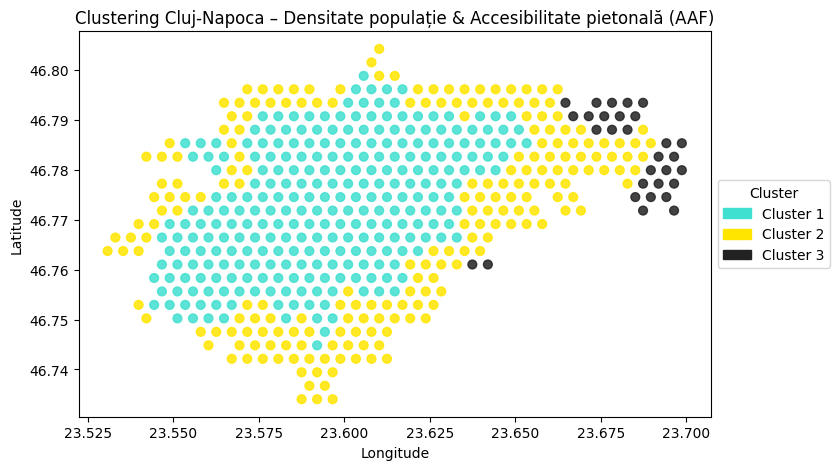


--- TABEL CLUSTERE AAF ---
   cluster_aaf  Densitate (loc/ha)  Acces mediu pietonal (AAF, min)  \
0            1           39.734421                         8.780630   
1            2           10.449637                        20.653694   
2            3            9.943465                        50.106767   

   Număr puncte  
0           273  
1           209  
2            30  


In [15]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# 1. Citește fișierul Excel
df = pd.read_excel(r'D:\Disertatie\output_fix_with_zones.xlsx')

# 2. Confirmă coloane (doar pentru verificare, poți comenta după ce rulezi o dată)
print(df.columns)

# 3. Creează geometrie punct (cu 'centroid_lon' și 'centroid_lat')
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']),
    crs='EPSG:4326'
)

# 4. Creează density_ha dacă nu există deja
if 'density_ha' not in gdf.columns and 'density' in gdf.columns:
    gdf['density_ha'] = gdf['density'] * 0.01

# 5. Creează AAF dacă nu există deja (media dintre coloanele *_f)
if 'AAF' not in gdf.columns:
    pietonal_cols = [c for c in gdf.columns if c.endswith('_f')]
    gdf['AAF'] = gdf[pietonal_cols].mean(axis=1)

# 6. Elimină punctele cu valori lipsă (doar pentru clustering)
gdf = gdf.dropna(subset=['density_ha', 'AAF'])

# 7. Clustering (density_ha & AAF)
X = gdf[['density_ha', 'AAF']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans_aaf = KMeans(n_clusters=3, random_state=42, n_init=10)
gdf['cluster_aaf'] = kmeans_aaf.fit_predict(X_scaled) + 1

# 8. Colormap & legendă
custom_colors_aaf = ['#40e0d0', '#ffe600', '#222222']
cmap_aaf = mcolors.ListedColormap(custom_colors_aaf)

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    column='cluster_aaf',
    cmap=cmap_aaf,
    legend=False,
    categorical=True,
    ax=ax,
    markersize=40,
    alpha=0.85
)

handles = [
    mpatches.Patch(color=custom_colors_aaf[i], label=f'Cluster {i+1}')
    for i in range(3)
]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")
plt.title('Clustering Cluj-Napoca – Densitate populație & Accesibilitate pietonală (AAF)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 9. Tabel rezumat pe clustere (doar media pentru densitate și AAF)
tabel_cluster = gdf.groupby('cluster_aaf').agg({
    'density_ha': 'mean',
    'AAF': 'mean',
    'zona': 'count'
}).reset_index().rename(columns={
    'density_ha': 'Densitate (loc/ha)',
    'AAF': 'Acces mediu pietonal (AAF, min)',
    'zona': 'Număr puncte'
})

print("\n--- TABEL CLUSTERE AAF ---")
print(tabel_cluster)

# (Opțional) Salvează tabelul într-un Excel pentru comparații ulterioare
tabel_cluster.to_excel(r'D:\Disertatie\cluster_summary_aaf.xlsx', index=False)


Index(['a_f', 'b_f', 'c_f', 'd_f', 'e_f', 'f_f', 'g_f', 'h_f', 'i_f', 'l_f',
       'a_b', 'b_b', 'c_b', 'd_b', 'e_b', 'f_b', 'g_b', 'h_b', 'i_b', 'l_b',
       'radius', 'population', 'centroid_lon', 'centroid_lat', 'area_km2',
       'density', 'geometry', 'index_right', 'name', 'zona'],
      dtype='object')


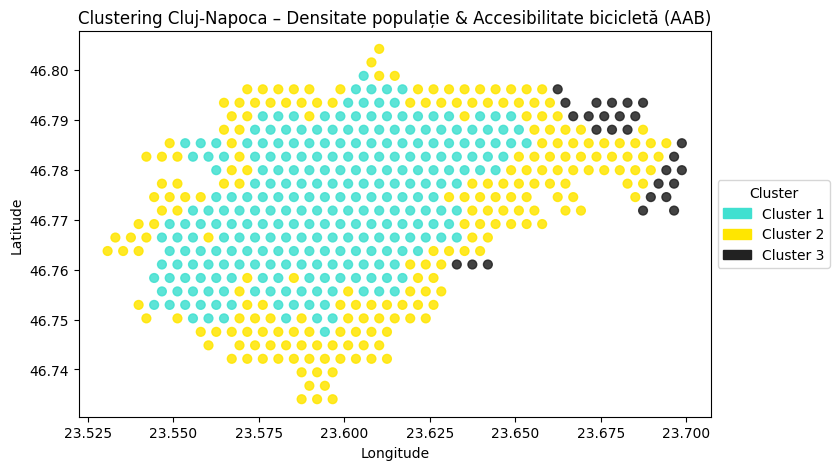


--- TABEL CLUSTERE AAB ---
   cluster_aab  Densitate (loc/ha)  Acces mediu bicicletă (AAB, min)  \
0            1           40.193219                          3.981849   
1            2           11.192078                          8.220600   
2            3            8.011658                         19.140407   

   Număr puncte  
0           265  
1           220  
2            27  


In [14]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# 1. Citește fișierul Excel
df = pd.read_excel(r'D:\Disertatie\output_fix_with_zones.xlsx')

# 2. Confirmă coloane (doar pentru verificare, poți comenta după ce rulezi o dată)
print(df.columns)

# 3. Creează geometrie punct (cu 'centroid_lon' și 'centroid_lat')
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']),
    crs='EPSG:4326'
)

# 4. Creează density_ha dacă nu există deja
if 'density_ha' not in gdf.columns and 'density' in gdf.columns:
    gdf['density_ha'] = gdf['density'] * 0.01

# 5. Creează AAB dacă nu există deja (media dintre coloanele *_b)
if 'AAB' not in gdf.columns:
    biciclete_cols = [c for c in gdf.columns if c.endswith('_b')]
    gdf['AAB'] = gdf[biciclete_cols].mean(axis=1)

# 6. Elimină punctele cu valori lipsă (doar pentru clustering)
gdf = gdf.dropna(subset=['density_ha', 'AAB'])

# 7. Clustering (density_ha & AAB)
X = gdf[['density_ha', 'AAB']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans_aab = KMeans(n_clusters=3, random_state=42, n_init=10)
gdf['cluster_aab'] = kmeans_aab.fit_predict(X_scaled) + 1

# 8. Colormap & legendă
custom_colors_aab = ['#40e0d0', '#ffe600', '#222222']
cmap_aab = mcolors.ListedColormap(custom_colors_aab)

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    column='cluster_aab',
    cmap=cmap_aab,
    legend=False,
    categorical=True,
    ax=ax,
    markersize=40,
    alpha=0.85
)

handles = [
    mpatches.Patch(color=custom_colors_aab[i], label=f'Cluster {i+1}')
    for i in range(3)
]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")
plt.title('Clustering Cluj-Napoca – Densitate populație & Accesibilitate bicicletă (AAB)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 9. Tabel rezumat pe clustere (doar media pentru densitate și AAB)
tabel_cluster = gdf.groupby('cluster_aab').agg({
    'density_ha': 'mean',
    'AAB': 'mean',
    'zona': 'count'
}).reset_index().rename(columns={
    'density_ha': 'Densitate (loc/ha)',
    'AAB': 'Acces mediu bicicletă (AAB, min)',
    'zona': 'Număr puncte'
})

print("\n--- TABEL CLUSTERE AAB ---")
print(tabel_cluster)

# (Opțional) Salvează tabelul într-un Excel pentru comparații ulterioare
tabel_cluster.to_excel(r'D:\Disertatie\cluster_summary_aab.xlsx', index=False)



--- STATISTICI DESCRIPTIVE ---
              AAF         AAB
count  512.000000  512.000000
mean    16.048705    6.602564
std     11.715547    4.134435
min      2.501000    1.712000
25%      7.311500    3.610000
50%     12.769500    5.453500
75%     20.814000    8.478000
max     72.347000   26.519000

--- CORELATIE AAF vs AAB ---
          AAF       AAB
AAF  1.000000  0.979373
AAB  0.979373  1.000000


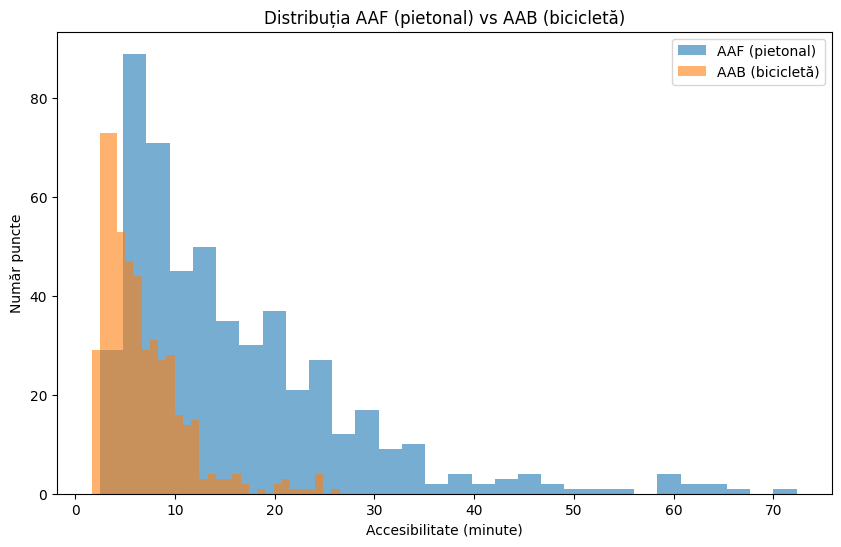

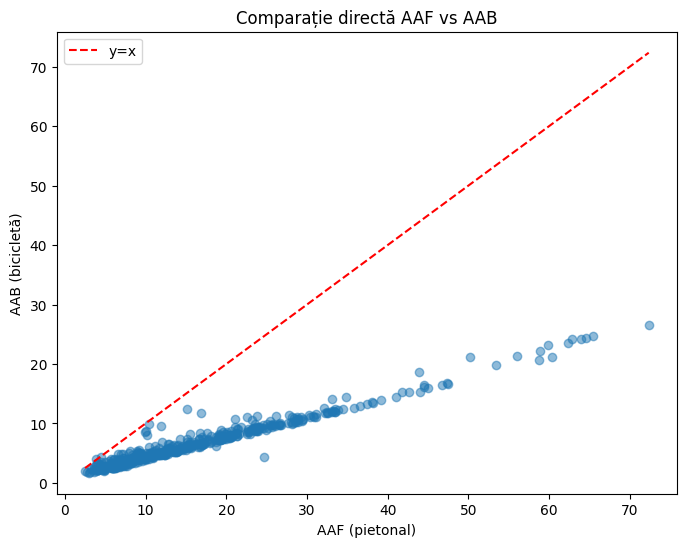

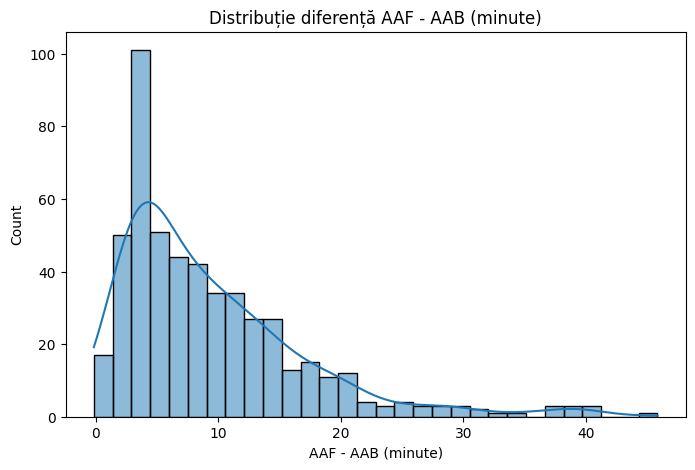


--- MEDII PE ZONE ---
        density_ha    AAF    AAB  diff_AAF_AAB
zona                                          
Zona 1       40.97   7.61   3.64          3.97
Zona 2       15.74  28.05  10.66         17.39
Zona 3       26.81  13.85   5.93          7.92
Zona 4       20.15  13.07   5.66          7.41


In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Citește datele
df = pd.read_excel(r'D:\Disertatie\output_fix_with_zones.xlsx')

# 2. Creează geometrie punct
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']),
    crs='EPSG:4326'
)

# 3. Asigură-te că ai density_ha, AAF și AAB calculate corect
if 'density_ha' not in gdf.columns:
    gdf['density_ha'] = gdf['density'] * 0.01

if 'AAF' not in gdf.columns:
    pietonal_cols = [c for c in gdf.columns if c.endswith('_f')]
    gdf['AAF'] = gdf[pietonal_cols].mean(axis=1)

if 'AAB' not in gdf.columns:
    biciclete_cols = [c for c in gdf.columns if c.endswith('_b')]
    gdf['AAB'] = gdf[biciclete_cols].mean(axis=1)

# 4. Elimină valorile lipsă
gdf = gdf.dropna(subset=['density_ha', 'AAF', 'AAB'])

# 5. Statistici descriptive pentru AAF și AAB
print("\n--- STATISTICI DESCRIPTIVE ---")
print(gdf[['AAF', 'AAB']].describe())

# 6. Corelația dintre AAF și AAB
print("\n--- CORELATIE AAF vs AAB ---")
print(gdf[['AAF', 'AAB']].corr())

# 7. Histograme comparative
plt.figure(figsize=(10,6))
plt.hist(gdf['AAF'], bins=30, alpha=0.6, label='AAF (pietonal)')
plt.hist(gdf['AAB'], bins=30, alpha=0.6, label='AAB (bicicletă)')
plt.xlabel('Accesibilitate (minute)')
plt.ylabel('Număr puncte')
plt.legend()
plt.title("Distribuția AAF (pietonal) vs AAB (bicicletă)")
plt.show()

# 8. Scatterplot direct AAF vs AAB
plt.figure(figsize=(8,6))
plt.scatter(gdf['AAF'], gdf['AAB'], alpha=0.5)
plt.xlabel('AAF (pietonal)')
plt.ylabel('AAB (bicicletă)')
plt.title('Comparație directă AAF vs AAB')
plt.plot([gdf['AAF'].min(), gdf['AAF'].max()], [gdf['AAF'].min(), gdf['AAF'].max()], 'r--', label='y=x')
plt.legend()
plt.show()

# 9. Diferență între AAF și AAB (distribuție diferență absolută)
gdf['diff_AAF_AAB'] = gdf['AAF'] - gdf['AAB']
plt.figure(figsize=(8,5))
sns.histplot(gdf['diff_AAF_AAB'], bins=30, kde=True)
plt.title('Distribuție diferență AAF - AAB (minute)')
plt.xlabel('AAF - AAB (minute)')
plt.show()

# 10. Tabel medii pe zone (dacă există coloana 'zona')
if 'zona' in gdf.columns:
    tabel_zone = gdf.groupby('zona').agg({
        'density_ha': 'mean',
        'AAF': 'mean',
        'AAB': 'mean',
        'diff_AAF_AAB': 'mean'
    }).round(2)
    print("\n--- MEDII PE ZONE ---")
    print(tabel_zone)


In [239]:
tabel_cluster_aaf = gdf.groupby('cluster_aaf').agg({
    'density_ha': ['mean', 'std', 'min', 'max'],
    'AAF': ['mean', 'std', 'min', 'max']
}).reset_index()

# Rotunjire pentru prezentare academică
tabel_cluster_aaf = tabel_cluster_aaf.round(2)
print(tabel_cluster_aaf)


  cluster_aaf density_ha                        AAF                     
                    mean   std    min    max   mean    std    min    max
0           1      39.73  9.43  18.12  52.64   8.78   3.98   2.50  24.71
1           2      10.45  7.96   0.00  29.66  20.65   6.57   7.56  34.84
2           3       9.94  8.89   0.00  29.91  50.11  10.50  35.77  72.35


C:\Users\rober\AppData\Local\Temp\ipykernel_31908\71353180.py:87: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Zone funcționale", loc="upper left")


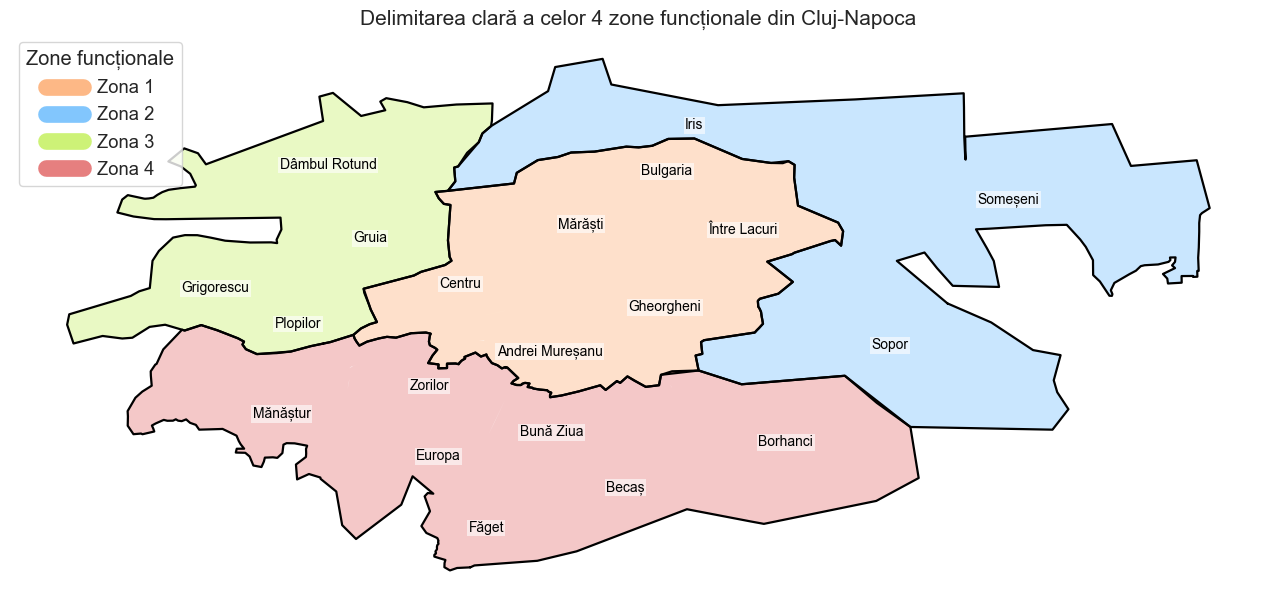


=== Zona 1 ===
{
  "type": "Polygon",
  "coordinates": [
    [
      [
        23.6125238,
        46.7562241
      ],
      [
        23.6108334,
        46.7548941
      ],
      [
        23.6100301,
        46.7555935
      ],
      [
        23.6068048,
        46.7546809
      ],
      [
        23.6041811,
        46.7540548
      ],
      [
        23.6024581,
        46.7537955
      ],
      [
        23.6024581,
        46.7541443
      ],
      [
        23.6026296,
        46.7544207
      ],
      [
        23.6026302,
        46.7544874
      ],
      [
        23.6022555,
        46.7546244
      ],
      [
        23.6020167,
        46.7548492
      ],
      [
        23.6008804,
        46.7549508
      ],
      [
        23.5999131,
        46.7551129
      ],
      [
        23.5998084,
        46.7552174
      ],
      [
        23.5992066,
        46.7553149
      ],
      [
        23.5990905,
        46.7553337
      ],
      [
        23.5993646,
        46.7

In [ ]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import MultiPolygon, Polygon

# 1. Definire zone și cartiere
zona_dict = {
    "Zona 1": ["Centru", "Andrei Mureșanu", "Gheorgheni", "Între Lacuri", "Mărăști", "Bulgaria"],
    "Zona 2": ["Someșeni", "Iris", "Sopor"],
    "Zona 3": ["Grigorescu", "Gruia", "Dâmbul Rotund", "Plopilor"],
    "Zona 4": ["Mănăștur", "Zorilor", "Europa", "Bună Ziua", "Becaș", "Borhanci", "Făget"]
}
lista_cartiere = [c for l in zona_dict.values() for c in l]

# 2. Extrage limita Cluj-Napoca
city = ox.geocode_to_gdf(query="R3277038", by_osmid=True)
polygon = city.iloc[0].geometry

# 3. Extrage cartiere (polygonale) din OSM
tags = {"place": ["suburb", "neighbourhood"]}
cartiere = ox.features_from_polygon(polygon, tags=tags)
cartiere = cartiere[cartiere.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
cartiere.reset_index(drop=True, inplace=True)

# 4. Filtrare doar cartierele cerute
cartiere_ok = cartiere[cartiere['name'].isin(lista_cartiere)].copy()
cartiere_gasite = set(cartiere_ok['name'])
cartiere_lipsa = [c for c in lista_cartiere if c not in cartiere_gasite]
if cartiere_lipsa:
    warnings.warn(f"Cartiere fără poligon OSM și eliminate: {cartiere_lipsa}")

# 5. Asociază zona
def atribuie_zona(nume):
    for zona, lista in zona_dict.items():
        if nume in lista:
            return zona
    return "Necunoscut"
cartiere_ok['zona'] = cartiere_ok['name'].apply(atribuie_zona)

# 6. Agregare per zonă (dissolve)
gdf_zones = cartiere_ok.dissolve(by="zona", as_index=True)

# 7. Plot: DOAR conturul exterior (NU boundary cartiere!), cu umplere și linie subțire
zone_colors = {
    "Zona 1": "#fc9245",
    "Zona 2": "#3fa8fc",
    "Zona 3": "#b3eb2e",
    "Zona 4": "#da3b3b"
}
fig, ax = plt.subplots(1, 1, figsize=(16, 11))

# Umplere semitransparentă (pentru context)
for zona, row in gdf_zones.iterrows():
    gpd.GeoSeries(row.geometry).plot(
        ax=ax, 
        facecolor=zone_colors[zona], 
        edgecolor="none",
        alpha=0.28, 
        label=zona, 
        zorder=1
    )

# Trasăm doar conturul exterior real – fără interioare
for zona, row in gdf_zones.iterrows():
    # Extragem conturul exterior (poate fi MultiPolygon sau Polygon)
    geom = row.geometry
    if isinstance(geom, MultiPolygon):
        exteriors = [poly.exterior for poly in geom.geoms]
    elif isinstance(geom, Polygon):
        exteriors = [geom.exterior]
    else:
        exteriors = []
    for exterior in exteriors:
        xs, ys = exterior.xy
        ax.plot(xs, ys, color="black", linewidth=1.6, zorder=3)

# Etichete cartiere, la centroid
for idx, row in cartiere_ok.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(row['name'], (centroid.x, centroid.y), fontsize=10, color='black', ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

# Legendă simplificată
for zona in gdf_zones.index:
    ax.plot([], [], color=zone_colors[zona], label=zona, linewidth=12, alpha=0.65)
ax.legend(title="Zone funcționale", loc="upper left")
ax.set_title("Delimitarea clară a celor 4 zone funcționale din Cluj-Napoca", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

# 8. Coordonate GeoJSON pentru fiecare zonă
import json
for zona, row in gdf_zones.iterrows():
    geojson_zone = row.geometry.__geo_interface__
    print(f"\n=== {zona} ===")
    print(json.dumps(geojson_zone, indent=2))

# 9. Observații privind lipsa unor cartiere
if cartiere_lipsa:
    print("\n⚠️ Cartiere fără poligon OSM și neincluse:", cartiere_lipsa)
    print("Soluție: completare manuală sau alte surse GIS locale.")
else:
    print("\n✔️ Toate cartierele cerute au poligon și au fost delimitate corect.")


C:\Users\rober\AppData\Local\Temp\ipykernel_27704\3671189579.py:89: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  urban_polygon = gdf_zones.unary_union


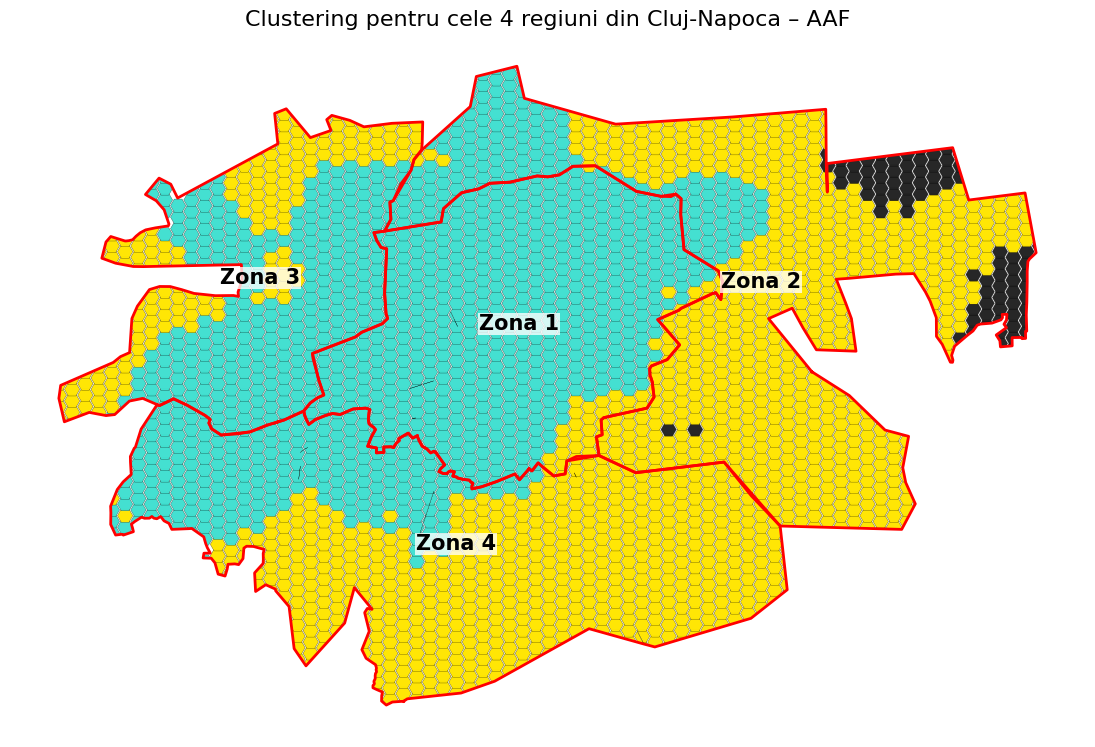


=== Distribuție hexagoane pe zone reale și clustere – AAF ===
cluster_pietonal  1.0  2.0  3.0
zona                           
Zona 1            509   31    0
Zona 2            153  634   86
Zona 3            282  180    0
Zona 4            233  589    0


In [20]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon, MultiPolygon
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import cKDTree
import warnings

# 1. Definește zonele și cartierele
zona_dict = {
    "Zona 1": ["Centru", "Andrei Mureșanu", "Gheorgheni", "Între Lacuri", "Mărăști", "Bulgaria"],
    "Zona 2": ["Someșeni", "Iris", "Sopor"],
    "Zona 3": ["Grigorescu", "Gruia", "Dâmbul Rotund", "Plopilor"],
    "Zona 4": ["Mănăștur", "Zorilor", "Europa", "Bună Ziua", "Becaș", "Borhanci", "Făget"]
}
lista_cartiere = [c for l in zona_dict.values() for c in l]

# 2. Limita Cluj-Napoca
city = ox.geocode_to_gdf(query="R3277038", by_osmid=True)
polygon = city.iloc[0].geometry

# 3. Extrage cartiere din OSM
tags = {"place": ["suburb", "neighbourhood"]}
cartiere = ox.features_from_polygon(polygon, tags=tags)
cartiere = cartiere[cartiere.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
cartiere.reset_index(drop=True, inplace=True)

# 4. Filtrare doar cartierele cerute
cartiere_ok = cartiere[cartiere['name'].isin(lista_cartiere)].copy()
cartiere_gasite = set(cartiere_ok['name'])
cartiere_lipsa = [c for c in lista_cartiere if c not in cartiere_gasite]
if cartiere_lipsa:
    warnings.warn(f"Cartiere fără poligon OSM și eliminate: {cartiere_lipsa}")

# 5. Asociază zona și agregă
def atribuie_zona(nume):
    for zona, lista in zona_dict.items():
        if nume in lista:
            return zona
    return "Necunoscut"
cartiere_ok['zona'] = cartiere_ok['name'].apply(atribuie_zona)
gdf_zones = cartiere_ok.dissolve(by="zona", as_index=True)

# 6. Citește punctele din Excel
df = pd.read_excel(r'D:\Disertatie\output_fix_with_zones.xlsx')
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']),
    crs='EPSG:4326'
)
if 'density_ha' not in gdf.columns:
    gdf['density_ha'] = gdf['density'] * 0.01
if 'AAF' not in gdf.columns:
    f_cols = [c for c in gdf.columns if c.endswith('_f')]
    gdf['AAF'] = gdf[f_cols].mean(axis=1)
gdf = gdf.dropna(subset=['density_ha', 'AAF'])

# 7. Proiecție metrică pentru spatial join/metri
gdf = gdf.to_crs(3857)
gdf_zones = gdf_zones.to_crs(3857)

# 8. Creează grid hexagonal dens
def create_hex_grid(polygon, hex_size, crs):
    minx, miny, maxx, maxy = polygon.bounds
    dx = hex_size * 3**0.5
    dy = hex_size * 1.5
    hexagons = []
    x = minx
    col = 0
    while x < maxx + dx:
        y = miny - (dy / 2 if col % 2 else 0)
        while y < maxy + dy:
            corners = [
                (x + hex_size * np.cos(np.pi/3 * i), y + hex_size * np.sin(np.pi/3 * i))
                for i in range(6)
            ]
            hexagon = Polygon(corners)
            if hexagon.intersects(polygon):
                hexagons.append(hexagon.intersection(polygon))
            y += dy
        x += dx
        col += 1
    return gpd.GeoDataFrame({'geometry': hexagons}, crs=crs)

urban_polygon = gdf_zones.unary_union
hex_size = 150  # metri
gdf_hex = create_hex_grid(urban_polygon, hex_size, gdf_zones.crs)

# 9. Agregă valorile punctelor pe fiecare hexagon
for var in ['density_ha', 'AAF']:
    gdf_hex[var] = np.nan

for idx, hexagon in gdf_hex.iterrows():
    points_in_hex = gdf[gdf.within(hexagon.geometry)]
    if not points_in_hex.empty:
        for var in ['density_ha', 'AAF']:
            gdf_hex.at[idx, var] = points_in_hex[var].mean()

# 10. Atribuie zona fiecărui hexagon după centroid
gdf_hex['zona'] = None
for zona, row in gdf_zones.iterrows():
    mask = gdf_hex.centroid.within(row.geometry)
    gdf_hex.loc[mask, 'zona'] = zona  # index-ul gdf_zones = nume zonă
gdf_hex = gdf_hex[~gdf_hex['zona'].isnull()].copy()

# 11. Clustering K-Means pe hexagoane AAF + completare lipsă
custom_colors = ['#40e0d0', '#ffe600', '#222222']
k = 3
vars = ['density_ha', 'AAF']
cluster_col = 'cluster_pietonal'
valid_mask = gdf_hex[vars].notnull().all(axis=1)
gdf_hex[cluster_col] = np.nan

if valid_mask.sum() > 0:
    X = gdf_hex.loc[valid_mask, vars].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    gdf_hex.loc[valid_mask, cluster_col] = kmeans.fit_predict(X_scaled) + 1

# Completează hexagoanele fără date cu clusterul vecinilor
nodata_mask = ~valid_mask
if nodata_mask.sum() > 0 and valid_mask.sum() > 0:
    coords_all = np.array(list(zip(gdf_hex.geometry.centroid.x, gdf_hex.geometry.centroid.y)))
    coords_valid = coords_all[valid_mask.values]
    clusters_valid = gdf_hex.loc[valid_mask, cluster_col].values.astype(int)
    tree = cKDTree(coords_valid)
    for idx in gdf_hex[nodata_mask].index:
        pt = gdf_hex.at[idx, 'geometry'].centroid
        dist, nn_idx = tree.query([[pt.x, pt.y]], k=6)
        neighbor_clusters = clusters_valid[nn_idx[0]]
        counts = np.bincount(neighbor_clusters)
        fill_cluster = np.argmax(counts)
        gdf_hex.at[idx, cluster_col] = fill_cluster

# 12. Plot cu contur exterior pe zone, etichete și titlu
fig, ax = plt.subplots(figsize=(13, 12))
gdf_hex.plot(
    column=cluster_col, 
    cmap=mcolors.ListedColormap(custom_colors),
    ax=ax, 
    edgecolor='k', 
    linewidth=0.18, 
    legend=False, 
    alpha=0.98, 
    zorder=2
)

for zona, row in gdf_zones.iterrows():
    geom = row.geometry
    if isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            xs, ys = poly.exterior.xy
            ax.plot(xs, ys, color='red', linewidth=2, zorder=3)
    elif isinstance(geom, Polygon):
        xs, ys = geom.exterior.xy
        ax.plot(xs, ys, color='red', linewidth=2, zorder=3)
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, zona, color='black', fontsize=15, fontweight='bold',
            ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.78, pad=0.8))

titlu = "Clustering pentru cele 4 regiuni din Cluj-Napoca – AAF"
ax.set_title(titlu, fontsize=16)
ax.legend([], [], frameon=False)
ax.axis('off')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 13. Tabel sumar zone-cluster
tab = pd.crosstab(gdf_hex['zona'], gdf_hex[cluster_col], dropna=False)
print(f"\n=== Distribuție hexagoane pe zone reale și clustere – AAF ===")
print(tab)


C:\Users\rober\AppData\Local\Temp\ipykernel_27704\384047507.py:89: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  urban_polygon = gdf_zones.unary_union


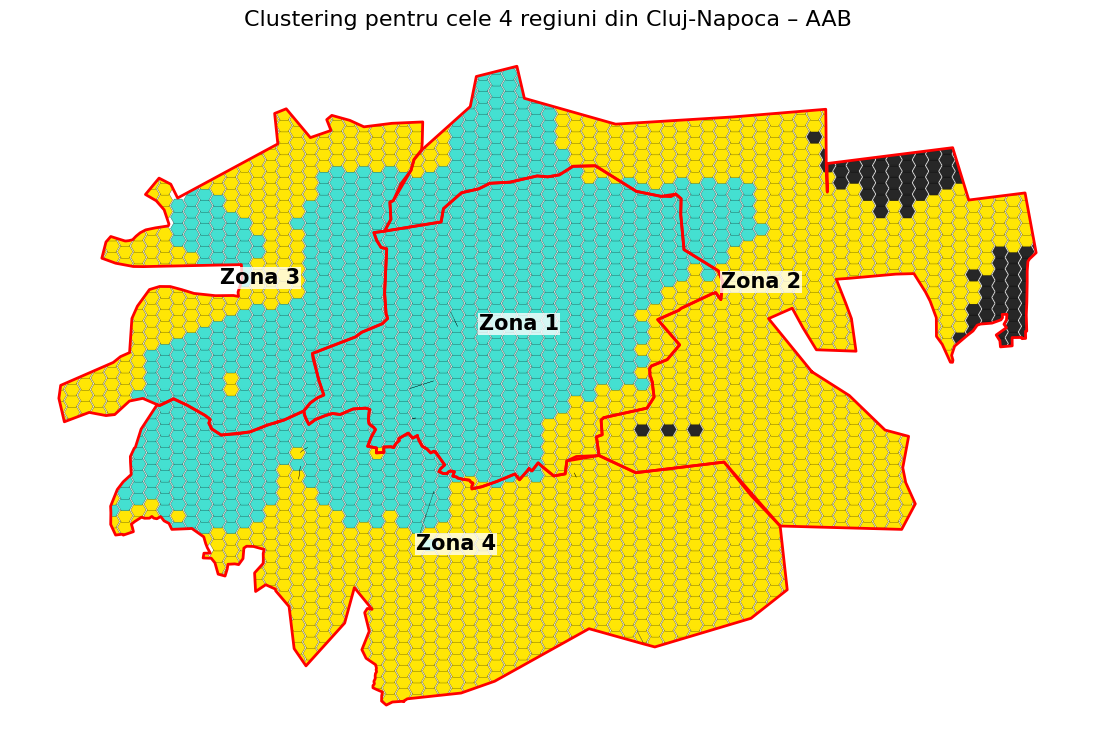


=== Distribuție hexagoane pe zone reale și clustere – BICICLETA (AAB) ===
cluster_bicicleta  1.0  2.0  3.0
zona                            
Zona 1              52  488    0
Zona 2             650  135   88
Zona 3             226  236    0
Zona 4             628  194    0


In [25]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon, MultiPolygon
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import cKDTree
import warnings

# 1. Definește zonele și cartierele
zona_dict = {
    "Zona 1": ["Centru", "Andrei Mureșanu", "Gheorgheni", "Între Lacuri", "Mărăști", "Bulgaria"],
    "Zona 2": ["Someșeni", "Iris", "Sopor"],
    "Zona 3": ["Grigorescu", "Gruia", "Dâmbul Rotund", "Plopilor"],
    "Zona 4": ["Mănăștur", "Zorilor", "Europa", "Bună Ziua", "Becaș", "Borhanci", "Făget"]
}
lista_cartiere = [c for l in zona_dict.values() for c in l]

# 2. Limita Cluj-Napoca
city = ox.geocode_to_gdf(query="R3277038", by_osmid=True)
polygon = city.iloc[0].geometry

# 3. Extrage cartiere din OSM
tags = {"place": ["suburb", "neighbourhood"]}
cartiere = ox.features_from_polygon(polygon, tags=tags)
cartiere = cartiere[cartiere.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
cartiere.reset_index(drop=True, inplace=True)

# 4. Filtrare doar cartierele cerute
cartiere_ok = cartiere[cartiere['name'].isin(lista_cartiere)].copy()
cartiere_gasite = set(cartiere_ok['name'])
cartiere_lipsa = [c for c in lista_cartiere if c not in cartiere_gasite]
if cartiere_lipsa:
    warnings.warn(f"Cartiere fără poligon OSM și eliminate: {cartiere_lipsa}")

# 5. Asociază zona și agregă
def atribuie_zona(nume):
    for zona, lista in zona_dict.items():
        if nume in lista:
            return zona
    return "Necunoscut"
cartiere_ok['zona'] = cartiere_ok['name'].apply(atribuie_zona)
gdf_zones = cartiere_ok.dissolve(by="zona", as_index=True)

# 6. Citește punctele (centroizi, densitate, aaf, aab) din Excel
df = pd.read_excel(r'D:\Disertatie\output_fix_with_zones.xlsx')
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['centroid_lon'], df['centroid_lat']),
    crs='EPSG:4326'
)
if 'density_ha' not in gdf.columns:
    gdf['density_ha'] = gdf['density'] * 0.01
if 'AAB' not in gdf.columns:
    b_cols = [c for c in gdf.columns if c.endswith('_b')]
    gdf['AAB'] = gdf[b_cols].mean(axis=1)
gdf = gdf.dropna(subset=['density_ha', 'AAB'])

# 7. Transformă la EPSG:3857 pentru spatial join/metri
gdf = gdf.to_crs(3857)
gdf_zones = gdf_zones.to_crs(3857)

# 8. Creează grid hexagonal dens
def create_hex_grid(polygon, hex_size, crs):
    minx, miny, maxx, maxy = polygon.bounds
    dx = hex_size * 3**0.5
    dy = hex_size * 1.5
    hexagons = []
    x = minx
    col = 0
    while x < maxx + dx:
        y = miny - (dy / 2 if col % 2 else 0)
        while y < maxy + dy:
            corners = [
                (x + hex_size * np.cos(np.pi/3 * i), y + hex_size * np.sin(np.pi/3 * i))
                for i in range(6)
            ]
            hexagon = Polygon(corners)
            if hexagon.intersects(polygon):
                hexagons.append(hexagon.intersection(polygon))
            y += dy
        x += dx
        col += 1
    return gpd.GeoDataFrame({'geometry': hexagons}, crs=crs)

urban_polygon = gdf_zones.unary_union
hex_size = 150  # metri
gdf_hex = create_hex_grid(urban_polygon, hex_size, gdf_zones.crs)

# 9. Agregă valorile punctelor pe fiecare hexagon
for var in ['density_ha', 'AAB']:
    gdf_hex[var] = np.nan

for idx, hexagon in gdf_hex.iterrows():
    points_in_hex = gdf[gdf.within(hexagon.geometry)]
    if not points_in_hex.empty:
        for var in ['density_ha', 'AAB']:
            gdf_hex.at[idx, var] = points_in_hex[var].mean()

# 10. Atribuie zona fiecărui hexagon după centroid
gdf_hex['zona'] = None
for zona, row in gdf_zones.iterrows():
    mask = gdf_hex.centroid.within(row.geometry)
    gdf_hex.loc[mask, 'zona'] = zona  # index-ul gdf_zones = nume zonă
gdf_hex = gdf_hex[~gdf_hex['zona'].isnull()].copy()

# 11. Clustering K-Means pe hexagoane + completare
custom_colors = ['#ffe600', '#40e0d0', '#222222']  # Cluster 1 galben, 2 turcoaz, 3 negru
k = 3

vars = ['density_ha', 'AAB']
cluster_col = f'cluster_bicicleta'
valid_mask = gdf_hex[vars].notnull().all(axis=1)
gdf_hex[cluster_col] = np.nan

if valid_mask.sum() > 0:
    X = gdf_hex.loc[valid_mask, vars].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    gdf_hex.loc[valid_mask, cluster_col] = kmeans.fit_predict(X_scaled) + 1

nodata_mask = ~valid_mask
if nodata_mask.sum() > 0 and valid_mask.sum() > 0:
    coords_all = np.array(list(zip(gdf_hex.geometry.centroid.x, gdf_hex.geometry.centroid.y)))
    coords_valid = coords_all[valid_mask.values]
    clusters_valid = gdf_hex.loc[valid_mask, cluster_col].values.astype(int)
    tree = cKDTree(coords_valid)
    for idx in gdf_hex[nodata_mask].index:
        pt = gdf_hex.at[idx, 'geometry'].centroid
        dist, nn_idx = tree.query([[pt.x, pt.y]], k=6)
        neighbor_clusters = clusters_valid[nn_idx[0]]
        counts = np.bincount(neighbor_clusters)
        fill_cluster = np.argmax(counts)
        gdf_hex.at[idx, cluster_col] = fill_cluster

# 12. Plot cu contur exterior pe zone, etichete și titlu
fig, ax = plt.subplots(figsize=(13, 12))
gdf_hex.plot(
    column=cluster_col, 
    cmap=mcolors.ListedColormap(custom_colors),
    ax=ax, 
    edgecolor='k', 
    linewidth=0.18, 
    legend=False, 
    alpha=0.98, 
    zorder=2
)
for zona, row in gdf_zones.iterrows():
    geom = row.geometry
    if isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            xs, ys = poly.exterior.xy
            ax.plot(xs, ys, color='red', linewidth=2, zorder=3)
    elif isinstance(geom, Polygon):
        xs, ys = geom.exterior.xy
        ax.plot(xs, ys, color='red', linewidth=2, zorder=3)
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, zona, color='black', fontsize=15, fontweight='bold',
            ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.78, pad=0.8))

titlu = "Clustering pentru cele 4 regiuni din Cluj-Napoca – AAB"
ax.set_title(titlu, fontsize=16)
ax.legend([], [], frameon=False)
ax.axis('off')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 13. Tabel sumar zone-cluster
tab = pd.crosstab(gdf_hex['zona'], gdf_hex[cluster_col], dropna=False)
print("\n=== Distribuție hexagoane pe zone reale și clustere – BICICLETA (AAB) ===")
print(tab)


In [292]:
import pandas as pd
import numpy as np

cluster_labels = ['1', '2', '3']

def get_cluster_stats(gdf, value_col, cluster_col):
    # Forțează ca etichetele clusterului să fie string ('1','2','3')
    clust = gdf[cluster_col].astype(int).astype(str)
    grouped = gdf.groupby(clust)[value_col]
    stats = pd.DataFrame({
        'Mean': grouped.mean().round(2),
        'Std. dev.': grouped.std().round(2),
        'Min': grouped.min().round(2),
        'Max': grouped.max().round(2),
    })
    stats = stats.T
    stats = stats.reindex(columns=cluster_labels, fill_value=np.nan)
    return stats

# Construim tabelul lat
tabel = pd.DataFrame()

# Populare pentru "Population density" și "AAF" la cluster_pietonal
density_aaf = get_cluster_stats(gdf_hex, 'density_ha', 'cluster_pietonal')
aaf = get_cluster_stats(gdf_hex, 'AAF', 'cluster_pietonal')

# Populare pentru "Population density" și "AAB" la cluster_bicicleta
density_aab = get_cluster_stats(gdf_hex, 'density_ha', 'cluster_bicicleta')
aab = get_cluster_stats(gdf_hex, 'AAB', 'cluster_bicicleta')

# Asamblare tabel (ca în exemplu)
rows = []
for varname, df1, df2 in [
    ('Population density', density_aaf, density_aab),
    ('AAF', aaf, aab)
]:
    for stat in ['Mean', 'Std. dev.', 'Min', 'Max']:
        row = [varname if stat == 'Mean' else '', stat]
        row += list(df1.loc[stat, cluster_labels])
        row += list(df2.loc[stat, cluster_labels])
        rows.append(row)

final_table = pd.DataFrame(rows, columns=[
    'Variable', 'Summary Statistics',
    'AAF_Cluster 1', 'AAF_Cluster 2', 'AAF_Cluster 3',
    'AAB_Cluster 1', 'AAB_Cluster 2', 'AAB_Cluster 3'
])

print(final_table)
final_table.to_excel("table9_clusters_characteristics.xlsx", index=False)


             Variable Summary Statistics  AAF_Cluster 1  AAF_Cluster 2  \
0  Population density               Mean          39.31          10.43   
1                              Std. dev.           9.51           7.96   
2                                    Min          18.12           0.00   
3                                    Max          52.64          29.66   
4                 AAF               Mean           9.01          21.15   
5                              Std. dev.           4.22           6.47   
6                                    Min           2.50           9.51   
7                                    Max          24.71          35.77   

   AAF_Cluster 3  AAB_Cluster 1  AAB_Cluster 2  AAB_Cluster 3  
0           6.16          11.03          39.73           6.06  
1           5.85           8.33           9.29           5.77  
2           0.00           0.00          18.12           0.00  
3          23.69          32.10          52.64          23.69  
4          51

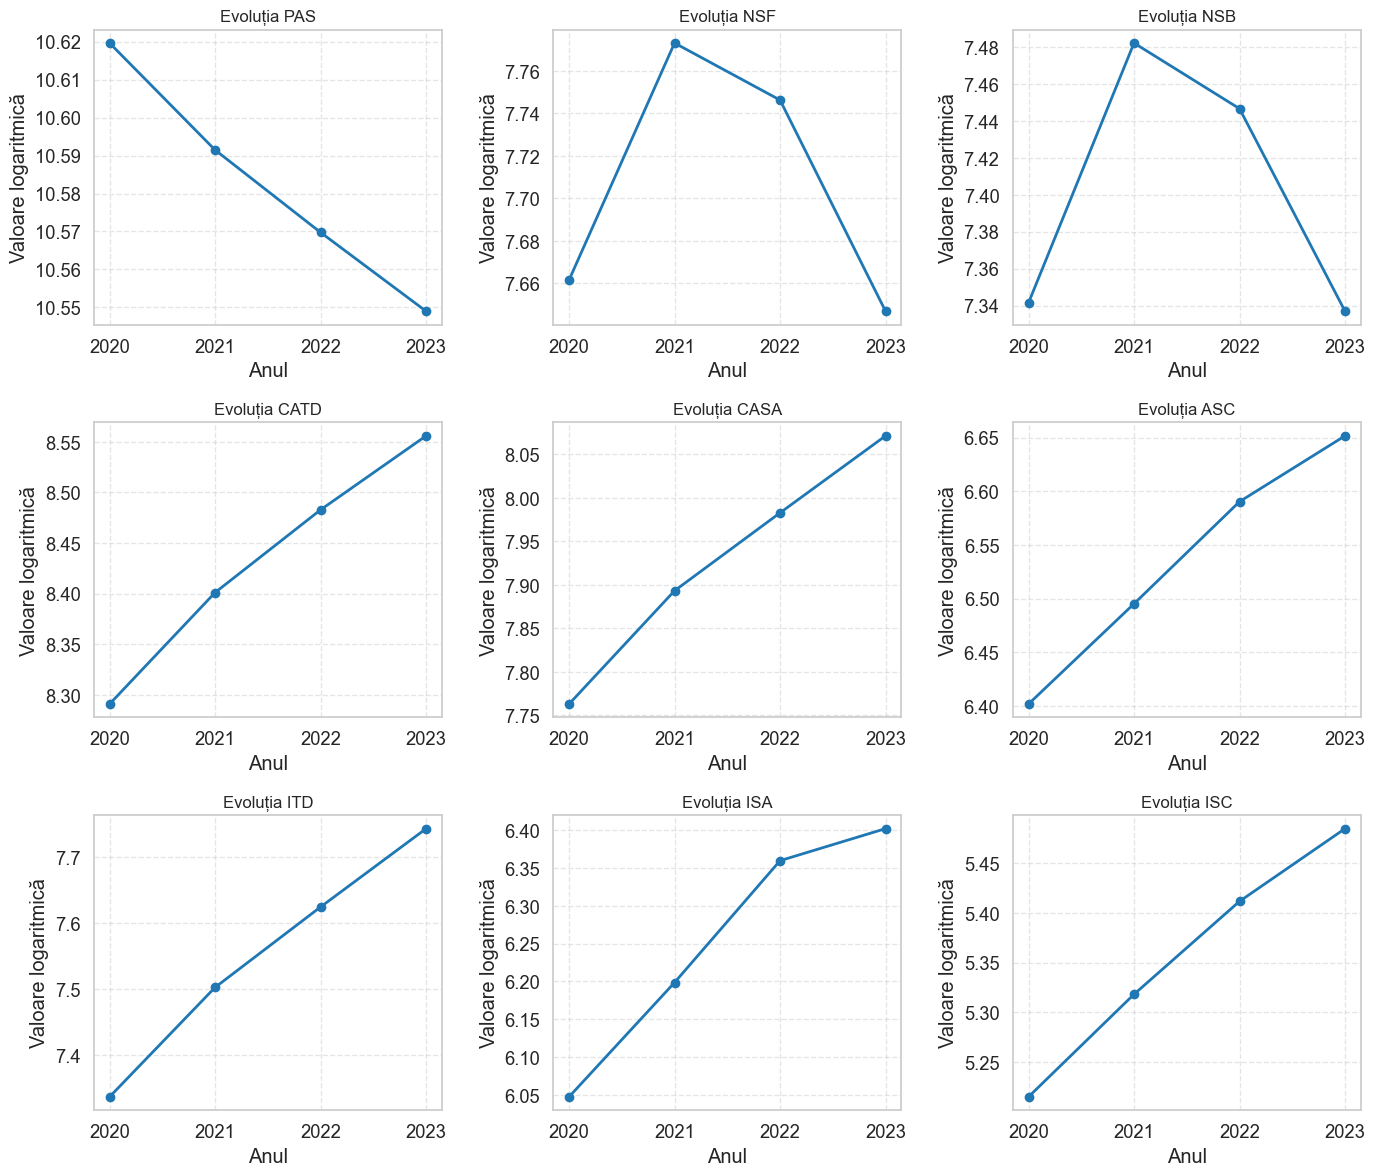

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Citește datele din fișierul Excel
df = pd.read_excel('Date Socio-Demografice.xlsx')

# Setează lista de indicatori și titluri în română
indicators = ['PAS', 'NSF', 'NSB', 'CATD', 'CASA', 'ASC', 'ITD', 'ISA', 'ISC']
titles = [
    'Evoluția PAS',   # Pensionari de asigurări sociale de stat
    'Evoluția NSF',   # Număr șomere femei
    'Evoluția NSB',   # Număr șomeri bărbați
    'Evoluția CATD',  # Cifra de afaceri transport & depozitare
    'Evoluția CASA',  # Cifra de afaceri sănătate & asistență socială
    'Evoluția ASC',   # Cifra de afaceri cultură
    'Evoluția ITD',   # Investiții transport & depozitare
    'Evoluția ISA',   # Investiții sănătate & asistență
    'Evoluția ISC'    # Investiții culturale
]

# Pregătește subploturile
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

years = df['An']

for i, indicator in enumerate(indicators):
    # Aplică transformarea logaritmică
    y = np.log(df[indicator])
    axes[i].plot(years, y, marker='o', color='tab:blue', linewidth=2)
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].set_xlabel("Anul")
    axes[i].set_ylabel("Valoare logaritmică")
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].set_xticks(years)

plt.tight_layout()
plt.show()
